MOUNT GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


SETUP

In [ ]:
from pathlib import Path
import sys

DRIVE_ROOT = Path('/content/drive/MyDrive/SemanticCorrespondenceDrive')

# Verifica che la cartella esista (non crearla!)
if not DRIVE_ROOT.exists():
    raise FileNotFoundError(
        f"❌ Cartella non trovata: {DRIVE_ROOT}\n"
        f"Assicurati di aver creato uno shortcut della cartella condivisa in MyDrive.\n"
        f"Se lo shortcut esiste già, controlla che il nome sia esattamente 'SemanticCorrespondence'"
    )

# Verifica che contenga il dataset
dataset_path = DRIVE_ROOT / 'SPair-71k'
if not dataset_path.exists():
    raise FileNotFoundError(
        f"❌ Dataset non trovato in: {dataset_path}\n"
        f"La cartella {DRIVE_ROOT.name} esiste ma non contiene 'SPair-71k'.\n"
        f"Verifica che lo shortcut punti alla cartella corretta."
    )

print(f"✓ Cartella condivisa trovata: {DRIVE_ROOT}")
print(f"✓ Dataset trovato: {dataset_path}")

!pip install -q torch torchvision timm tqdm scikit-image matplotlib opencv-python pandas

print("✓ Dependencies installed")

✓ Cartella condivisa trovata: /content/drive/MyDrive/SemanticCorrespondenceDrive
✓ Dataset trovato: /content/drive/MyDrive/SemanticCorrespondenceDrive/SPair-71k
✓ Dependencies installed


CLONE SAM (Segment Anything Model)

In [ ]:
SAM_PATH = DRIVE_ROOT / 'segment-anything'
if not SAM_PATH.exists():
    !git clone https://github.com/facebookresearch/segment-anything.git {SAM_PATH} --depth 1
    print("✓ SAM cloned")
else:
    print("✓ SAM found")

sys.path.append(str(SAM_PATH))

✓ SAM found


IMPORTS

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import json
from segment_anything import sam_model_registry

print("✓ Imports complete")

✓ Imports complete


CONFIGURATION AND CHECKPOINT CHECK

In [ ]:
CONFIG = {
    'backbone_size': 'base',   # 'base', 'large', 'huge'
    'image_size': 512,
    'patch_size': 16,
    'feature_layer': 9,         # (0-11 for base)
    'batch_size': 4,            # Match with fine-tuned evaluation
    'max_samples': None,        # Set to None to process all samples
    'pck_thresholds': [0.05, 0.1, 0.15, 0.2],
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'dataset_path': DRIVE_ROOT / 'SPair-71k',
}

print(f"\nSAM Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")


SAM Configuration:
  backbone_size: base
  image_size: 512
  patch_size: 16
  feature_layer: 9
  batch_size: 4
  max_samples: None
  pck_thresholds: [0.05, 0.1, 0.15, 0.2]
  device: cuda
  dataset_path: /content/drive/MyDrive/SemanticCorrespondenceDrive/SPair-71k


DATASET


In [ ]:
class SPairDataset(Dataset):
    def __init__(self, root_dir, split='test', image_size=224, max_samples=None):
        self.root_dir = Path(root_dir)
        self.image_size = image_size

        # Find split file
        split_file = self.root_dir / 'Layout' / 'large' / f'{split}.txt'
        if split == 'train':
            split_file = self.root_dir / 'Layout' / 'large' / 'trn.txt'

        if not split_file.exists():
            split_file = self.root_dir / 'Layout' / 'small' / f'{split}.txt'
            if split == 'train':
                split_file = self.root_dir / 'Layout' / 'small' / 'trn.txt'

        if not split_file.exists():
            raise FileNotFoundError(f"Split file not found: {split}")

        # Build annotation cache first
        self._build_annotation_cache()

        # Load pairs and filter those with annotations
        self.pairs = []
        category_count = {}
        skipped = 0

        with open(split_file, 'r') as f:
            lines = f.readlines()
            if max_samples:
                lines = lines[:max_samples]

            for line in lines:
                parts = line.strip().split(':')
                if len(parts) < 2:
                    continue

                pair_info = parts[0].split('-')
                if len(pair_info) < 3:
                    continue

                category = parts[1].strip()
                src_img = f"{pair_info[1]}.jpg"
                tgt_img = f"{pair_info[2]}.jpg"

                # Check if annotation exists
                cache_key = f"{src_img}-{tgt_img}-{category}"
                if cache_key not in self._anno_cache:
                    skipped += 1
                    continue

                self.pairs.append({
                    'src_img': src_img,
                    'tgt_img': tgt_img,
                    'category': category
                })

                category_count[category] = category_count.get(category, 0) + 1

        print(f"✓ Loaded {len(self.pairs)} pairs with annotations ({split})")
        if skipped > 0:
            print(f"  Skipped {skipped} pairs without annotations")
        print(f"✓ Categories: {len(category_count)} - {', '.join(sorted(category_count.keys()))}")

    def _build_annotation_cache(self):
        """Build cache mapping (src_img, tgt_img, category) -> annotation file"""
        anno_dir = self.root_dir / 'PairAnnotation' / 'test'
        self._anno_cache = {}

        if not anno_dir.exists():
            print(f"Warning: Annotation directory not found: {anno_dir}")
            return

        print("Building annotation cache...")
        for json_file in anno_dir.glob("*.json"):
            try:
                with open(json_file, 'r') as f:
                    anno_data = json.load(f)
                    src_img = anno_data.get('src_imname', '')
                    tgt_img = anno_data.get('trg_imname', '') or anno_data.get('tgt_imname', '')
                    cat = anno_data.get('category', '')
                    key = f"{src_img}-{tgt_img}-{cat}"
                    self._anno_cache[key] = json_file
            except:
                continue

        print(f"✓ Cached {len(self._anno_cache)} annotations")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        # Load images
        src_path = self.root_dir / 'JPEGImages' / pair['category'] / pair['src_img']
        tgt_path = self.root_dir / 'JPEGImages' / pair['category'] / pair['tgt_img']

        src_img = Image.open(src_path).convert('RGB')
        tgt_img = Image.open(tgt_path).convert('RGB')

        src_orig_size = src_img.size
        tgt_orig_size = tgt_img.size

        # Resize images
        src_img = src_img.resize((self.image_size, self.image_size), Image.BILINEAR)
        tgt_img = tgt_img.resize((self.image_size, self.image_size), Image.BILINEAR)

        src_tensor = self._to_tensor(src_img)
        tgt_tensor = self._to_tensor(tgt_img)

        # Load annotation from cache
        cache_key = f"{pair['src_img']}-{pair['tgt_img']}-{pair['category']}"
        anno_path = self._anno_cache[cache_key]

        with open(anno_path, 'r') as f:
            anno = json.load(f)

        src_kps = np.array(anno['src_kps'], dtype=np.float32)
        tgt_kps = np.array(anno['trg_kps'] if 'trg_kps' in anno else anno['tgt_kps'], dtype=np.float32)

        # Scale keypoints to resized image
        src_kps[:, 0] = src_kps[:, 0] * self.image_size / src_orig_size[0]
        src_kps[:, 1] = src_kps[:, 1] * self.image_size / src_orig_size[1]
        tgt_kps[:, 0] = tgt_kps[:, 0] * self.image_size / tgt_orig_size[0]
        tgt_kps[:, 1] = tgt_kps[:, 1] * self.image_size / tgt_orig_size[1]

        # Mark valid keypoints
        valid = np.array([(kp[0] >= 0 and kp[1] >= 0) for kp in tgt_kps], dtype=bool)

        return {
            'src_img': src_tensor,
            'tgt_img': tgt_tensor,
            'src_kps': torch.from_numpy(src_kps),
            'tgt_kps': torch.from_numpy(tgt_kps),
            'valid': torch.from_numpy(valid),
            'category': pair['category']
        }

    def _to_tensor(self, img):
        """Convert PIL image to SAM-normalized tensor"""
        # Convert to tensor [0, 255]
        tensor = torch.tensor(np.array(img)).permute(2, 0, 1).float()

        # SAM normalization
        mean = torch.tensor([123.675, 116.28, 103.53]).view(3, 1, 1)
        std = torch.tensor([58.395, 57.12, 57.375]).view(3, 1, 1)

        return (tensor - mean) / std


LOAD BACKBONE

In [ ]:
def load_sam(size='base', device='cuda'):
    """Load SAM image encoder with automatic checkpoint download"""

    SIZE_MAPPING = {
        'base': {
            'model_name': 'vit_b',
            'checkpoint_file': 'sam_vit_b_01ec64.pth',
            'url': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
        },
        'large': {
            'model_name': 'vit_l',
            'checkpoint_file': 'sam_vit_l_0b3195.pth',
            'url': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth'
        },
        'huge': {
            'model_name': 'vit_h',
            'checkpoint_file': 'sam_vit_h_4b8939.pth',
            'url': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
        }
    }

    if size not in SIZE_MAPPING:
        raise ValueError(f"Invalid size '{size}'. Choose from: {list(SIZE_MAPPING.keys())}")

    model_name = SIZE_MAPPING[size]['model_name']
    checkpoint_file = SIZE_MAPPING[size]['checkpoint_file']
    checkpoint_url = SIZE_MAPPING[size]['url']

    # Define checkpoint path
    checkpoint_path = DRIVE_ROOT / 'segment-anything' / checkpoint_file

    # Download checkpoint if not exists
    if not checkpoint_path.exists():
        print(f"Downloading {size} checkpoint ({checkpoint_file})...")
        checkpoint_path.parent.mkdir(exist_ok=True, parents=True)
        !wget -q {checkpoint_url} -O {checkpoint_path}
        print(f"✓ Checkpoint downloaded")
    else:
        print(f"✓ Checkpoint found: {checkpoint_file}")

    print(f"Loading SAM {size} ({model_name})...")

    # Load full SAM model with checkpoint
    sam = sam_model_registry[model_name](checkpoint=str(checkpoint_path))

    # Extract only the image encoder
    image_encoder = sam.image_encoder
    image_encoder = image_encoder.to(device)
    image_encoder.eval()

    print(f"✓ SAM image encoder loaded")
    return image_encoder

backbone_sam = load_sam(
    CONFIG['backbone_size'],
    CONFIG['device']
)

✓ Checkpoint found: sam_vit_b_01ec64.pth
Loading SAM base (vit_b)...
✓ SAM image encoder loaded


FEATURE EXTRACTION

In [ ]:
class SAMFeatureExtractor:
    """Extract features from SAM image encoder at a specific layer"""
    def __init__(self, model, patch_size=16, device='cuda'):
        self.model = model
        self.patch_size = patch_size
        self.device = device
        self.hook_output = None
        # SAM always uses 1024x1024 input size (fixed architecture)
        self.sam_input_size = 1024

    def _hook(self, module, input, output):
        self.hook_output = output

    def extract(self, img, layer_idx=None):
        """Extract features from SAM encoder

        Args:
            img: Input image [B, 3, H, W] already normalized with SAM normalization
            layer_idx: Block index to extract from (0-11 for vit_b)

        Returns:
            features: Normalized features [B, H_feat, W_feat, D]
        """
        B, _, H, W = img.shape

        # Resize to SAM's native input size (1024x1024) if needed
        if H != self.sam_input_size or W != self.sam_input_size:
            img = F.interpolate(img, size=(self.sam_input_size, self.sam_input_size),
                               mode='bilinear', align_corners=False)

        # Hook into specific layer if requested
        if layer_idx is not None:
            hook = self.model.blocks[layer_idx].register_forward_hook(self._hook)

        # SAM image encoder forward pass
        # NOTE: No torch.no_grad() here to allow gradients during training
        # The caller should use torch.no_grad() context manager if needed
        x = self.model.patch_embed(img)

        if self.model.pos_embed is not None:
            x = x + self.model.pos_embed

        # Run through blocks
        for block in self.model.blocks:
            x = block(x)

        # Get features from hook or final output
        if layer_idx is not None and self.hook_output is not None:
            features = self.hook_output
            hook.remove()
            self.hook_output = None
        else:
            features = x

        # Reshape to spatial grid
        # SAM outputs [B, H_feat*W_feat, D] where H_feat=W_feat=64 for 1024x1024 input
        H_feat = self.sam_input_size // self.patch_size
        W_feat = self.sam_input_size // self.patch_size
        D = features.shape[-1]

        features = features.reshape(B, H_feat, W_feat, D)
        features = F.normalize(features, p=2, dim=-1)

        # Resize features back to match original input size
        if H != self.sam_input_size or W != self.sam_input_size:
            target_H = H // self.patch_size
            target_W = W // self.patch_size
            features = features.permute(0, 3, 1, 2)  # [B, D, H_feat, W_feat]
            features = F.interpolate(features, size=(target_H, target_W),
                                    mode='bilinear', align_corners=False)
            features = features.permute(0, 2, 3, 1)  # [B, H_feat, W_feat, D]
            features = F.normalize(features, p=2, dim=-1)

        return features

print("✓ SAM Feature Extractor defined")

✓ SAM Feature Extractor defined


CORRESPONDENCE

In [ ]:
def find_correspondences(src_feats, tgt_feats, src_kps_list, patch_size=16):
    """Find correspondences using nearest neighbor search in feature space

    Args:
        src_feats: Source features [B, H_s, W_s, D]
        tgt_feats: Target features [B, H_t, W_t, D]
        src_kps_list: List of source keypoints for each batch
        patch_size: Patch size of the model (default 16 for SAM)
    """
    B, H_s, W_s, D = src_feats.shape
    _, H_t, W_t, _ = tgt_feats.shape

    pred_kps_list = []

    for b in range(B):
        src_kps = src_kps_list[b]
        num_kps = src_kps.shape[0]

        # Convert to feature coordinates
        src_kps_feat = (src_kps / patch_size).long()
        src_kps_feat[:, 0] = torch.clamp(src_kps_feat[:, 0], 0, W_s - 1)
        src_kps_feat[:, 1] = torch.clamp(src_kps_feat[:, 1], 0, H_s - 1)

        pred_kps = torch.zeros_like(src_kps)

        for k in range(num_kps):
            x_f = src_kps_feat[k, 0]
            y_f = src_kps_feat[k, 1]

            src_vec = src_feats[b, y_f, x_f]
            tgt_flat = tgt_feats[b].reshape(-1, D)
            sims = torch.matmul(src_vec, tgt_flat.T)

            best_idx = torch.argmax(sims)
            y_pred = best_idx // W_t
            x_pred = best_idx % W_t

            pred_kps[k, 0] = x_pred * patch_size + patch_size // 2
            pred_kps[k, 1] = y_pred * patch_size + patch_size // 2

        pred_kps_list.append(pred_kps)

    return pred_kps_list

PCK METRIC

In [ ]:
def compute_pck(pred_kps, gt_kps, valid, thresholds, img_size):
    """Compute Percentage of Correct Keypoints (PCK)

    A keypoint prediction is "correct" if its Euclidean distance from
    the ground truth is less than threshold × image_size.

    Args:
        pred_kps: List of [N, 2] predicted keypoints
        gt_kps: List of [N, 2] ground truth keypoints
        valid: List of [N] boolean validity masks
        thresholds: List of threshold values (e.g., [0.05, 0.1, 0.15, 0.2])
        img_size: Image size for normalization

    Returns:
        dict: {
            'per_keypoint': {f'PCK@{threshold}': percentage, ...},
            'per_image': {f'PCK@{threshold}': percentage, ...}
        }
    """
    # Per-keypoint PCK (original metric)
    per_keypoint = {}

    for alpha in thresholds:
        threshold_pixels = alpha * img_size  # Convert to pixel distance
        correct = 0
        total = 0

        for b in range(len(pred_kps)):
            for k in range(len(pred_kps[b])):
                if not valid[b][k]:
                    continue  # Skip invalid keypoints

                # Compute Euclidean distance
                dist = torch.norm(pred_kps[b][k].float() - gt_kps[b][k].float()).item()

                if dist <= threshold_pixels:
                    correct += 1
                total += 1

        pck = (correct / total * 100) if total > 0 else 0.0
        per_keypoint[f'PCK@{alpha}'] = pck

    # Per-image PCK (mean of individual image PCKs)
    per_image = {}

    for alpha in thresholds:
        threshold_pixels = alpha * img_size
        image_pcks = []

        for b in range(len(pred_kps)):
            correct = 0
            total = 0

            for k in range(len(pred_kps[b])):
                if not valid[b][k]:
                    continue

                dist = torch.norm(pred_kps[b][k].float() - gt_kps[b][k].float()).item()

                if dist <= threshold_pixels:
                    correct += 1
                total += 1

            # PCK for this image
            img_pck = (correct / total * 100) if total > 0 else 0.0
            image_pcks.append(img_pck)

        # Mean PCK across all images
        mean_pck = np.mean(image_pcks) if image_pcks else 0.0
        per_image[f'PCK@{alpha}'] = mean_pck

    return {
        'per_keypoint': per_keypoint,
        'per_image': per_image
    }

EVALUATION

In [ ]:
def evaluate():
    print("\n" + "="*60)
    print("EVALUATION")
    print("="*60)

    dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='test',
        image_size=CONFIG['image_size'],
        max_samples=CONFIG['max_samples']
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch],
            'category': [item['category'] for item in batch]
        }

    dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)
    extractor = SAMFeatureExtractor(backbone_sam, CONFIG['patch_size'], CONFIG['device'])

    all_preds = []
    all_gts = []
    all_valids = []
    all_cats = []

    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(dataloader, desc="Processing"):
            src_img = batch['src_img'].to(CONFIG['device'])
            tgt_img = batch['tgt_img'].to(CONFIG['device'])
            src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
            valid = [v.to(CONFIG['device']) for v in batch['valid']]

            src_feats = extractor.extract(src_img, layer_idx=CONFIG['feature_layer'])
            tgt_feats = extractor.extract(tgt_img, layer_idx=CONFIG['feature_layer'])

            pred_kps = find_correspondences(src_feats, tgt_feats, src_kps, CONFIG['patch_size'])

            all_preds.extend([p.cpu() for p in pred_kps])
            all_gts.extend([g.cpu() for g in tgt_kps])
            all_valids.extend([v.cpu() for v in valid])
            all_cats.extend(batch['category'])

            # Clear GPU cache to prevent OOM
            del src_img, tgt_img, src_feats, tgt_feats, pred_kps
            torch.cuda.empty_cache()

    # Overall PCK (both per-keypoint and per-image)
    pck_results = compute_pck(all_preds, all_gts, all_valids, CONFIG['pck_thresholds'], CONFIG['image_size'])
    pck_overall = pck_results['per_keypoint']
    mean_per_image = pck_results['per_image']

    print("\nOverall Results (Per-Keypoint):")
    for threshold, pck in pck_overall.items():
        print(f"  {threshold}: {pck:.2f}%")

    print("\nMean Per-Image PCK:")
    for threshold, pck in mean_per_image.items():
        print(f"  {threshold}: {pck:.2f}%")

    # Per-category PCK
    unique_cats = sorted(set(all_cats))
    pck_by_cat = {}

    print(f"\nPer-Category Results (PCK@0.1):")
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        cat_preds = [all_preds[i] for i in cat_indices]
        cat_gts = [all_gts[i] for i in cat_indices]
        cat_valids = [all_valids[i] for i in cat_indices]

        if cat_preds:
            cat_pck = compute_pck(cat_preds, cat_gts, cat_valids, CONFIG['pck_thresholds'], CONFIG['image_size'])
            pck_by_cat[cat] = cat_pck
            print(f"  {cat}: {cat_pck['per_keypoint']['PCK@0.1']:.1f}%")

    # Results table - Per-Keypoint
    print("\n" + "="*100)
    print("RESULTS TABLE (PCK@0.1 - Per-Keypoint)")
    print("="*100)

    header = "Method".ljust(20) + " | "
    values_str = f"SAM [L{CONFIG['feature_layer']}]".ljust(20) + " | "

    for cat in unique_cats:
        header += f"{cat[:4]:>5} "
        if cat in pck_by_cat and pck_by_cat[cat]['per_keypoint'].get('PCK@0.1') is not None:
            values_str += f"{pck_by_cat[cat]['per_keypoint']['PCK@0.1']:>5.1f} "
        else:
            values_str += "  N/A "

    header += "| avg"
    values_str += f"| {pck_overall['PCK@0.1']:>5.1f}"

    print(header)
    print("-" * len(header))
    print(values_str)

    # Results table - Per-Image (Mean)
    print("\n" + "="*100)
    print("RESULTS TABLE (PCK@0.1 - Mean Per-Image)")
    print("="*100)

    header = "Method".ljust(20) + " | "
    values_str = f"SAM [L{CONFIG['feature_layer']}]".ljust(20) + " | "

    # Per-category mean per-image (already computed in pck_by_cat)
    cat_mean_per_image = {}
    for cat in unique_cats:
        if cat in pck_by_cat:
            cat_mean_per_image[cat] = pck_by_cat[cat]['per_image']

        header += f"{cat[:4]:>5} "
        if cat in cat_mean_per_image and cat_mean_per_image[cat].get('PCK@0.1') is not None:
            values_str += f"{cat_mean_per_image[cat]['PCK@0.1']:>5.1f} "
        else:
            values_str += "  N/A "

    header += "| avg"
    values_str += f"| {mean_per_image['PCK@0.1']:>5.1f}"

    print(header)
    print("-" * len(header))
    print(values_str)

    return {
        'overall': pck_overall,
        'mean_per_image': mean_per_image,
        'categories': pck_by_cat,
        'categories_mean_per_image': cat_mean_per_image,
        'predictions': all_preds,
        'ground_truth': all_gts,
        'valid': all_valids,
        'categories_list': all_cats,
        'dataset': dataset
    }

RUN EVALUATION

In [ ]:
results = evaluate()


EVALUATION
Building annotation cache...
✓ Cached 3497 annotations
✓ Loaded 3497 pairs with annotations (test)
  Skipped 8737 pairs without annotations
✓ Categories: 18 - aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor


Processing: 100%|██████████| 1749/1749 [1:02:24<00:00,  2.14s/it]



Overall Results:
  PCK@0.05: 17.18%
  PCK@0.1: 26.97%
  PCK@0.15: 35.80%
  PCK@0.2: 43.90%

Per-Category Results:
  aeroplane: PCK@0.1 = 27.2%
  bicycle: PCK@0.1 = 18.6%
  bird: PCK@0.1 = 36.0%
  boat: PCK@0.1 = 20.0%
  bottle: PCK@0.1 = 24.0%
  bus: PCK@0.1 = 22.4%
  car: PCK@0.1 = 22.3%
  cat: PCK@0.1 = 36.2%
  chair: PCK@0.1 = 17.4%
  cow: PCK@0.1 = 29.1%
  dog: PCK@0.1 = 29.1%
  horse: PCK@0.1 = 21.4%
  motorbike: PCK@0.1 = 19.6%
  person: PCK@0.1 = 37.3%
  pottedplant: PCK@0.1 = 28.0%
  sheep: PCK@0.1 = 18.7%
  train: PCK@0.1 = 31.5%
  tvmonitor: PCK@0.1 = 30.6%

RESULTS TABLE (PCK@0.1)
Method               |  aero  bicy  bird  boat  bott   bus   car   cat  chai   cow   dog  hors  moto  pers  pott  shee  trai  tvmo | avg
----------------------------------------------------------------------------------------------------------------------------------------
SAM [L9]             |  27.2  18.6  36.0  20.0  24.0  22.4  22.3  36.2  17.4  29.1  29.1  21.4  19.6  37.3  28.0  18.7  31.5  

VISUALIZE


VISUALIZATION


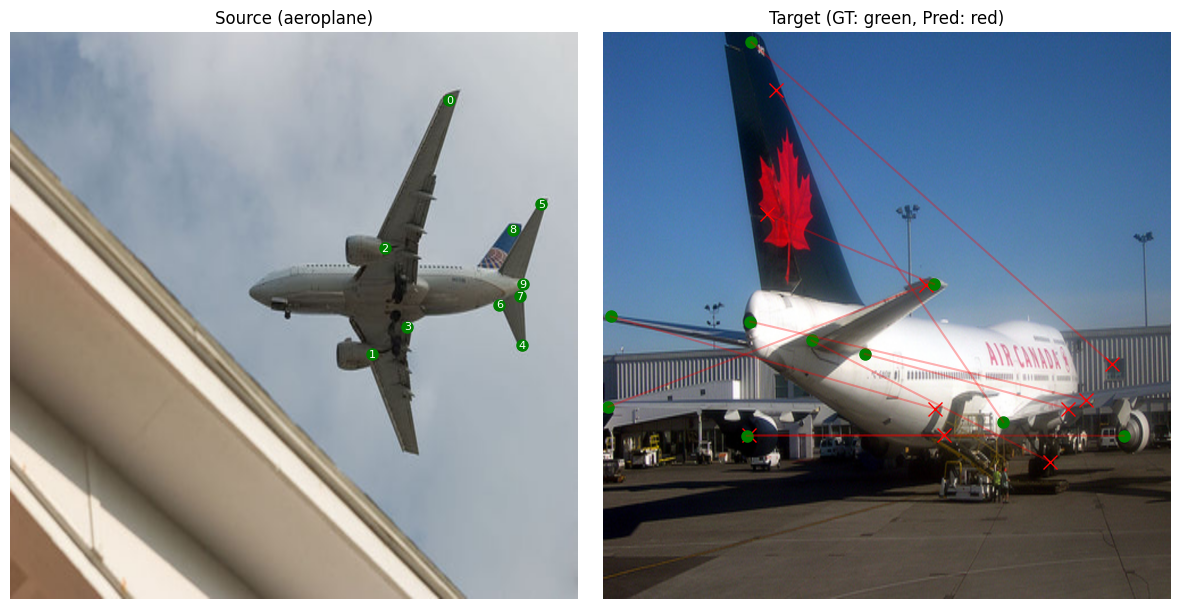

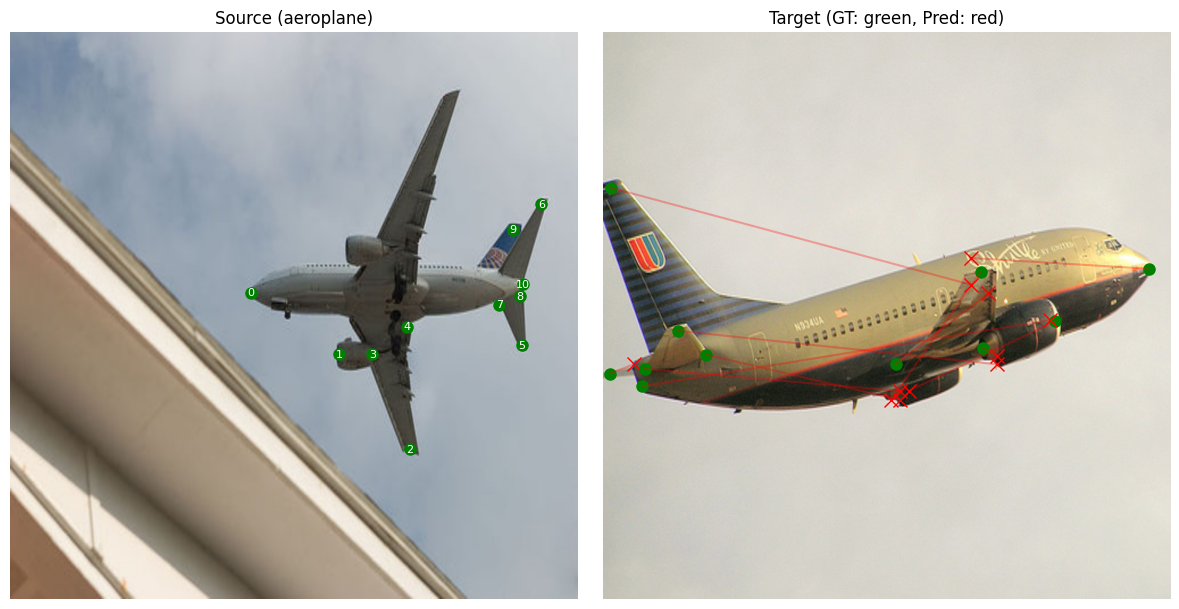

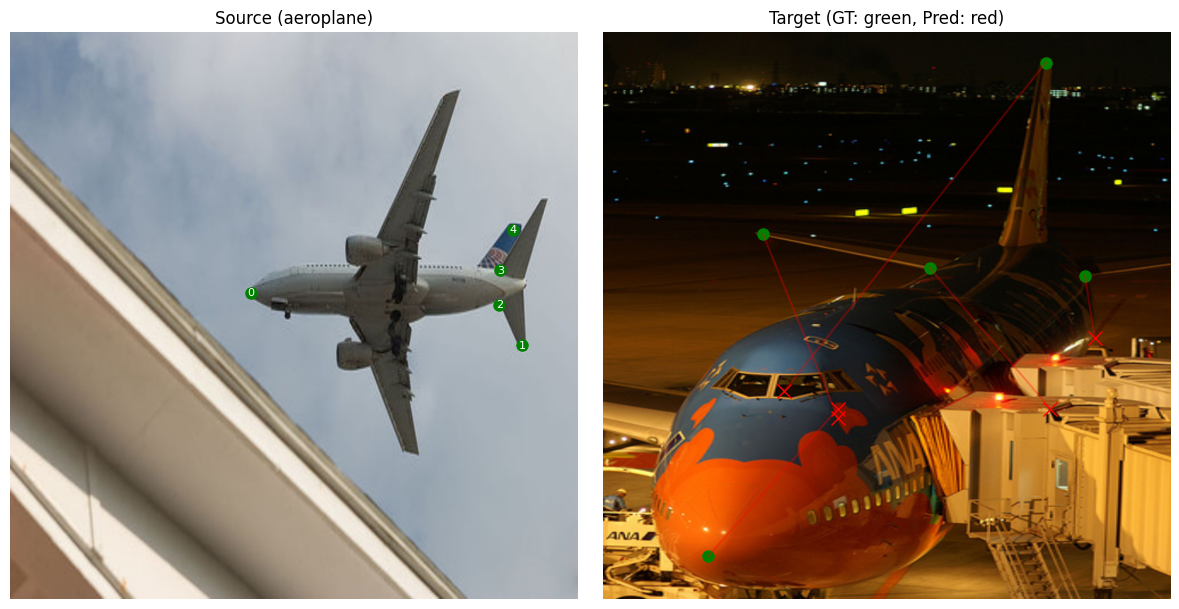

In [ ]:
def visualize(dataset, preds, gts, idx=0):
    sample = dataset[idx]

    # SAM denormalization
    mean = torch.tensor([123.675, 116.28, 103.53]).view(3, 1, 1)
    std = torch.tensor([58.395, 57.12, 57.375]).view(3, 1, 1)

    src_img = ((sample['src_img'] * std + mean) / 255.0).permute(1, 2, 0).numpy()
    tgt_img = ((sample['tgt_img'] * std + mean) / 255.0).permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(np.clip(src_img, 0, 1))
    axes[0].set_title(f"Source ({sample['category']})")
    axes[0].axis('off')

    for k, (x, y) in enumerate(sample['src_kps']):
        axes[0].plot(x, y, 'go', markersize=8)
        axes[0].text(x, y, str(k), color='white', fontsize=8, ha='center', va='center')

    axes[1].imshow(np.clip(tgt_img, 0, 1))
    axes[1].set_title("Target (GT: green, Pred: red)")
    axes[1].axis('off')

    for k, ((x_gt, y_gt), (x_pred, y_pred)) in enumerate(zip(gts[idx], preds[idx])):
        axes[1].plot(x_gt, y_gt, 'go', markersize=8)
        axes[1].plot(x_pred, y_pred, 'rx', markersize=10)
        axes[1].plot([x_gt, x_pred], [y_gt, y_pred], 'r-', alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("VISUALIZATION")
print("="*60)

for i in range(min(3, len(results['dataset']))):
    visualize(results['dataset'], results['predictions'], results['ground_truth'], i)

SAVE RESULTS

In [ ]:
results_dir = DRIVE_ROOT / 'results'
results_dir.mkdir(exist_ok=True)

# Save Per-Keypoint PCK scores
df_overall_kp = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'PCK_PerKeypoint': [results['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
})
df_overall_kp.to_csv(results_dir / f"sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_overall_per_keypoint.csv", index=False)

# Save Mean Per-Image PCK scores
df_overall_img = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'PCK_MeanPerImage': [results['mean_per_image'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
})
df_overall_img.to_csv(results_dir / f"sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_overall_mean_per_image.csv", index=False)

# Save combined overall results
df_overall_combined = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'PCK_PerKeypoint': [results['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']],
    'PCK_MeanPerImage': [results['mean_per_image'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
})
df_overall_combined.to_csv(results_dir / f"sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_overall_combined.csv", index=False)

# Per-category results - Per-Keypoint
category_data_kp = []
for cat in sorted(results['categories'].keys()):
    row = {'Category': cat}
    for threshold in CONFIG['pck_thresholds']:
        pck_key = f'PCK@{threshold}'
        row[pck_key] = results['categories'][cat]['per_keypoint'].get(pck_key, 0.0)
    category_data_kp.append(row)

# Add average row
avg_row_kp = {'Category': 'AVERAGE'}
for threshold in CONFIG['pck_thresholds']:
    avg_row_kp[f'PCK@{threshold}'] = results['overall'][f'PCK@{threshold}']
category_data_kp.append(avg_row_kp)

df_categories_kp = pd.DataFrame(category_data_kp)
df_categories_kp.to_csv(results_dir / f"sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_categories_per_keypoint.csv", index=False)

# Per-category results - Mean Per-Image
category_data_img = []
for cat in sorted(results['categories_mean_per_image'].keys()):
    row = {'Category': cat}
    for threshold in CONFIG['pck_thresholds']:
        pck_key = f'PCK@{threshold}'
        row[pck_key] = results['categories_mean_per_image'][cat].get(pck_key, 0.0)
    category_data_img.append(row)

# Add average row
avg_row_img = {'Category': 'AVERAGE'}
for threshold in CONFIG['pck_thresholds']:
    avg_row_img[f'PCK@{threshold}'] = results['mean_per_image'][f'PCK@{threshold}']
category_data_img.append(avg_row_img)

df_categories_img = pd.DataFrame(category_data_img)
df_categories_img.to_csv(results_dir / f"sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_categories_mean_per_image.csv", index=False)

print(f"\n✓ Results saved to {results_dir}")
print(f"\nOverall results:")
print(f"  - Combined: sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_overall_combined.csv")
print(f"  - Per-Keypoint: sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_overall_per_keypoint.csv")
print(f"  - Mean Per-Image: sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_overall_mean_per_image.csv")
print(f"\nPer-category results:")
print(f"  - Per-Keypoint: sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_categories_per_keypoint.csv")
print(f"  - Mean Per-Image: sam_{CONFIG['backbone_size']}_layer{CONFIG['feature_layer']}_categories_mean_per_image.csv")

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY - PER-KEYPOINT")
print("="*80)
print(df_categories_kp.to_string(index=False))

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY - MEAN PER-IMAGE")
print("="*80)
print(df_categories_img.to_string(index=False))

print("\n" + "="*60)
print("COMPLETE")
print("="*60)


✓ Results saved to /content/drive/MyDrive/SemanticCorrespondence/results
  - Overall: sam_base_layer9_overall.csv
  - Per-category: sam_base_layer9_categories.csv

FINAL RESULTS SUMMARY
   Category  PCK@0.05   PCK@0.1  PCK@0.15   PCK@0.2
  aeroplane 18.246293 27.208253 34.558349 43.649259
    bicycle 10.148976 18.621974 28.305400 37.802607
       bird 24.605678 35.962145 44.794953 52.602524
       boat 11.027027 20.000000 29.621622 37.189189
     bottle 15.184513 24.016939 30.913491 39.503932
        bus 16.741405 22.421525 29.671151 38.191330
        car 13.854854 22.337418 28.275212 35.438266
        cat 26.511370 36.217415 45.368830 52.800887
      chair 11.549296 17.370892 23.849765 30.516432
        cow 17.260788 29.080675 39.337086 48.280175
        dog 16.565809 29.122542 39.031770 46.596067
      horse 12.225476 21.449488 30.161054 37.701318
  motorbike 11.752786 19.554205 28.267477 38.297872
     person 25.562032 37.302248 46.544546 54.704413
pottedplant 19.251754 27.981294 3

## 2) Light Finetuning of the Last Layers
We unfreeze the last few layers of the backbone and fine-tune them using keypoint supervision.

FINE-TUNING CONFIGURATION

In [ ]:
# ============================================================================
# SAM FINE-TUNING CONFIGURATION (Anti-Overfitting)
# ============================================================================
#
# STRATEGY:
# - Fine-tune SAM image encoder on semantic correspondence task
# - Use keypoint supervision with correspondence loss
# - Unfreeze only last few blocks to prevent overfitting
# - Use small dataset split to reduce memorization
# - Monitor validation performance with early stopping

FT_CONFIG = {
    # Dataset configuration
    'use_small_split': True,          # Use SMALL dataset to reduce overfitting
    'max_train_samples': None,        # Use all samples from small split

    # Model configuration - SAM specific
    'unfreeze_last_n_blocks': 1,      # Unfreeze only last 1 block (SAM has 12 blocks for vit_b)
    'use_final_layer': True,          # Use final output instead of intermediate layer
                                       # Ensures gradients flow through unfrozen blocks

    # Training hyperparameters
    'learning_rate': 5e-6,            # Lower LR for large SAM model (more sensitive than DINOv2)
    'epochs': 5,                       # Max epochs with early stopping
    'batch_size': 2,                   # Smaller batch due to SAM's larger size (512x512)
    'temperature': 0.1,                # Softmax temperature for correspondence
    'weight_decay': 0.05,              # Strong regularization

    # Regularization
    'warmup_steps': 50,                # Warmup learning rate
    'max_grad_norm': 1.0,              # Gradient clipping
    'use_bidirectional_loss': True,    # Bidirectional consistency loss

    # Early stopping
    'use_early_stopping': True,
    'patience': 2,                     # Stop after 2 epochs without improvement
    'min_delta': 0.001,                # Minimum improvement threshold

    'device': CONFIG['device']
}

print("=" * 70)
print("SAM FINE-TUNING CONFIGURATION (Anti-Overfitting)")
print("=" * 70)
print("\nStrategy to prevent overfitting:")
print("  - Using SMALL dataset split")
print("  - Unfreezing only LAST 1 block of SAM encoder")
print("  - Using FINAL layer output (not intermediate layer 9)")
print("  - Lower learning rate (5e-6) - SAM is larger and more sensitive")
print("  - Smaller batch size (4) due to 512x512 image size")
print("  - Higher temperature (0.1)")
print("  - Strong weight decay (0.05)")
print("  - Early stopping with validation monitoring")
print("\nFull configuration:")
for k, v in FT_CONFIG.items():
    print(f"  {k}: {v}")

SAM FINE-TUNING CONFIGURATION (Anti-Overfitting)

Strategy to prevent overfitting:
  - Using SMALL dataset split
  - Unfreezing only LAST 1 block of SAM encoder
  - Using FINAL layer output (not intermediate layer 9)
  - Lower learning rate (5e-6) - SAM is larger and more sensitive
  - Smaller batch size (4) due to 512x512 image size
  - Higher temperature (0.1)
  - Strong weight decay (0.05)
  - Early stopping with validation monitoring

Full configuration:
  use_small_split: True
  max_train_samples: None
  unfreeze_last_n_blocks: 1
  use_final_layer: True
  learning_rate: 5e-06
  epochs: 5
  batch_size: 2
  temperature: 0.1
  weight_decay: 0.05
  warmup_steps: 50
  max_grad_norm: 1.0
  use_bidirectional_loss: True
  use_early_stopping: True
  patience: 2
  min_delta: 0.001
  device: cuda


UNFREEZE FUNCTION FOR SAM

In [ ]:
def unfreeze_last_n_blocks(model, n_blocks=1):
    """
    Unfreeze only the last N transformer blocks of SAM image encoder.

    SAM ViT-B has 12 transformer blocks in the image encoder.
    For preventing overfitting, we want MINIMAL capacity:
    - n_blocks=1: Only last block trainable (~8% of params)
    - n_blocks=2: Last 2 blocks (~16% of params)
    - n_blocks=3: Last 3 blocks (~24% of params)

    Args:
        model: SAM image encoder (not full SAM model)
        n_blocks: Number of last blocks to unfreeze

    Returns:
        model: Modified model with unfrozen blocks
    """
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # Get number of blocks in SAM encoder
    total_blocks = len(model.blocks)
    start_idx = total_blocks - n_blocks

    print(f"SAM image encoder has {total_blocks} transformer blocks")
    print(f"Unfreezing last {n_blocks} block(s): blocks {start_idx} to {total_blocks-1}")

    # Unfreeze only the last N blocks
    for i in range(start_idx, total_blocks):
        for param in model.blocks[i].parameters():
            param.requires_grad = True

    # Also unfreeze the neck (output projection) for better gradient flow
    if hasattr(model, 'neck'):
        for param in model.neck.parameters():
            param.requires_grad = True
        print("Also unfreezing neck (output projection)")

    # Count parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())

    print(f"\nTrainable parameters: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")
    print(f"Frozen parameters: {total-trainable:,} ({100*(total-trainable)/total:.1f}%)")

    return model

print("✓ Unfreeze function defined for SAM")

✓ Unfreeze function defined for SAM


DATASET WITH SPLIT SELECTION

In [ ]:
class SPairDatasetWithSplit(Dataset):
    """
    Extended SPair dataset that supports explicit 'large' and 'small' split selection.

    SPair-71k has two dataset sizes:
    - LARGE: ~53k training pairs (can cause overfitting during fine-tuning)
    - SMALL: ~10k training pairs (better for fine-tuning with limited capacity)

    For fine-tuning, we typically want use_small=True to prevent memorization.
    """

    def __init__(self, root_dir, split='test', image_size=512, max_samples=None, use_small=False):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.use_small = use_small

        # Determine split directory - EXPLICIT choice
        split_dir = 'small' if use_small else 'large'
        split_file = self.root_dir / 'Layout' / split_dir / f'{split}.txt'
        if split == 'train':
            split_file = self.root_dir / 'Layout' / split_dir / 'trn.txt'

        if not split_file.exists():
            raise FileNotFoundError(f"Split file not found: {split_file}")

        print(f"Using {split_dir.upper()} split: {split_file.name}")

        # First, read the split file to get the list of pairs we need
        needed_pairs = []
        with open(split_file, 'r') as f:
            lines = f.readlines()
            if max_samples:
                lines = lines[:max_samples]

            for line in lines:
                parts = line.strip().split(':')
                if len(parts) < 2:
                    continue

                pair_info = parts[0].split('-')
                if len(pair_info) < 3:
                    continue

                category = parts[1].strip()
                src_img = f"{pair_info[1]}.jpg"
                tgt_img = f"{pair_info[2]}.jpg"

                needed_pairs.append({
                    'src_img': src_img,
                    'tgt_img': tgt_img,
                    'category': category
                })

        # Build annotation cache with only needed pairs
        self._build_annotation_cache(needed_pairs)

        # Now filter pairs based on available annotations
        self.pairs = []
        category_count = {}
        skipped = 0

        for pair in needed_pairs:
            cache_key = f"{pair['src_img']}-{pair['tgt_img']}-{pair['category']}"
            if cache_key not in self._anno_cache:
                skipped += 1
                continue

            self.pairs.append(pair)
            category_count[pair['category']] = category_count.get(pair['category'], 0) + 1

        print(f"✓ Loaded {len(self.pairs)} pairs ({split}, {split_dir})")
        if skipped > 0:
            print(f"  Skipped {skipped} pairs without annotations")

    def _build_annotation_cache(self, needed_pairs):
        """Build cache by matching filenames WITHOUT opening files - ULTRA FAST!"""
        split_name = 'trn' if self.split == 'train' else self.split

        # Try to use local copy first (MUCH faster than Google Drive)
        LOCAL_ANNOTATION_DIR = Path('/tmp/SPair-71k-annotations')
        if LOCAL_ANNOTATION_DIR.exists():
            anno_dir = LOCAL_ANNOTATION_DIR / split_name
            print(f"Using LOCAL annotations (fast): {anno_dir}")
        else:
            # Fallback to Google Drive (slow)
            anno_dir = self.root_dir / 'PairAnnotation' / split_name
            print(f"Using DRIVE annotations: {anno_dir}")

        self._anno_cache = {}

        if not anno_dir.exists():
            print(f"Warning: Annotation directory not found: {anno_dir}")
            return

        # Build lookup dictionary for needed pairs (src, tgt, category)
        needed_lookup = {}
        for pair in needed_pairs:
            src_base = pair['src_img'].replace('.jpg', '')
            tgt_base = pair['tgt_img'].replace('.jpg', '')
            category = pair['category']
            # Key: (src_base, tgt_base, category) -> full key for cache
            lookup_key = (src_base, tgt_base, category)
            cache_key = f"{pair['src_img']}-{pair['tgt_img']}-{category}"
            needed_lookup[lookup_key] = cache_key

        print(f"Loading annotations for {len(needed_pairs)} pairs...")

        # CRITICAL: Get file list WITHOUT opening them (just filenames)
        print(f"  Scanning filenames (no file I/O)...")
        json_files = list(anno_dir.glob("*.json"))
        print(f"  Found {len(json_files):,} annotation files")

        loaded = 0
        sample_keys = []

        # Match by FILENAME ONLY - NO file opening!
        # SPair-71k format: {number}-{src}-{tgt}_{category}.json
        # Example: 000001-2008_000585-2008_002221_aeroplane.json
        for json_file in tqdm(json_files, desc="Matching annotations", leave=False):
            # Early exit if we found everything
            if loaded >= len(needed_pairs):
                break

            # Parse filename WITHOUT opening the file
            filename = json_file.stem  # Remove .json extension

            try:
                # Split by '-' to get parts
                parts = filename.split('-')
                if len(parts) >= 3:
                    # parts[0] = number (e.g., '000001')
                    src_base = parts[1]  # e.g., '2008_000585'
                    rest = parts[2]  # e.g., '2008_002221_aeroplane'

                    # Split rest by last underscore to separate tgt and category
                    last_underscore = rest.rfind('_')
                    if last_underscore > 0:
                        tgt_base = rest[:last_underscore]  # e.g., '2008_002221'
                        category = rest[last_underscore+1:]  # e.g., 'aeroplane'

                        # Check if this matches a needed pair
                        lookup_key = (src_base, tgt_base, category)
                        if lookup_key in needed_lookup:
                            cache_key = needed_lookup[lookup_key]
                            self._anno_cache[cache_key] = json_file
                            loaded += 1

                            # Collect first 3 keys as samples
                            if len(sample_keys) < 3:
                                sample_keys.append(cache_key)
            except:
                continue

        print(f"✓ Matched {len(self._anno_cache)} annotations (needed: {len(needed_pairs)})")
        if len(self._anno_cache) < len(needed_pairs):
            missing = len(needed_pairs) - len(self._anno_cache)
            print(f"  ⚠ Missing {missing} annotations")
        if sample_keys:
            print(f"  Sample matches:")
            for key in sample_keys:
                print(f"    - {key}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        src_path = self.root_dir / 'JPEGImages' / pair['category'] / pair['src_img']
        tgt_path = self.root_dir / 'JPEGImages' / pair['category'] / pair['tgt_img']

        src_img = Image.open(src_path).convert('RGB')
        tgt_img = Image.open(tgt_path).convert('RGB')

        src_orig_size = src_img.size
        tgt_orig_size = tgt_img.size

        src_img = src_img.resize((self.image_size, self.image_size), Image.BILINEAR)
        tgt_img = tgt_img.resize((self.image_size, self.image_size), Image.BILINEAR)

        src_tensor = self._to_tensor(src_img)
        tgt_tensor = self._to_tensor(tgt_img)

        cache_key = f"{pair['src_img']}-{pair['tgt_img']}-{pair['category']}"
        anno_path = self._anno_cache[cache_key]

        with open(anno_path, 'r') as f:
            anno = json.load(f)

        src_kps = np.array(anno['src_kps'], dtype=np.float32)
        tgt_kps = np.array(anno['trg_kps'] if 'trg_kps' in anno else anno['tgt_kps'], dtype=np.float32)

        # Scale keypoints to resized image
        src_kps[:, 0] = src_kps[:, 0] * self.image_size / src_orig_size[0]
        src_kps[:, 1] = src_kps[:, 1] * self.image_size / src_orig_size[1]
        tgt_kps[:, 0] = tgt_kps[:, 0] * self.image_size / tgt_orig_size[0]
        tgt_kps[:, 1] = tgt_kps[:, 1] * self.image_size / tgt_orig_size[1]

        valid = np.array([(kp[0] >= 0 and kp[1] >= 0) for kp in tgt_kps], dtype=bool)

        return {
            'src_img': src_tensor,
            'tgt_img': tgt_tensor,
            'src_kps': torch.from_numpy(src_kps),
            'tgt_kps': torch.from_numpy(tgt_kps),
            'valid': torch.from_numpy(valid),
            'category': pair['category']
        }

    def _to_tensor(self, img):
        """Convert PIL image to SAM-normalized tensor"""
        # Convert to tensor [0, 255]
        tensor = torch.tensor(np.array(img)).permute(2, 0, 1).float()

        # SAM normalization
        mean = torch.tensor([123.675, 116.28, 103.53]).view(3, 1, 1)
        std = torch.tensor([58.395, 57.12, 57.375]).view(3, 1, 1)

        return (tensor - mean) / std

print("✓ SPairDatasetWithSplit defined")

✓ SPairDatasetWithSplit defined


CORRESPONDENCE LOSS FUNCTIONS

In [ ]:
def correspondence_loss_bidirectional(src_feats, tgt_feats, src_kps, tgt_kps, valid, temperature=0.1):
    """
    Bidirectional InfoNCE loss for correspondence learning.

    Enforces consistency in both directions:
    1. Source keypoint features → corresponding target patches (src→tgt)
    2. Target keypoint features → corresponding source patches (tgt→src)

    This bidirectional constraint significantly improves learning quality.

    Args:
        src_feats: Source features [B, H, W, D]
        tgt_feats: Target features [B, H, W, D]
        src_kps: Source keypoints [list of [N_kps, 2] tensors]
        tgt_kps: Target keypoints [list of [N_kps, 2] tensors]
        valid: Valid keypoint mask [list of [N_kps] boolean tensors]
        temperature: Softmax temperature (higher = softer distributions)

    Returns:
        Average bidirectional loss
    """
    B, H, W, D = src_feats.shape
    patch_size = CONFIG['patch_size']

    total_loss = 0
    total_valid = 0

    for b in range(B):
        mask = valid[b]
        if not mask.any():
            continue

        s_kps = src_kps[b][mask]
        t_kps = tgt_kps[b][mask]

        # Convert keypoints to feature grid coordinates
        s_grid = (s_kps / patch_size).long()
        t_grid = (t_kps / patch_size).long()

        # Clamp to valid range
        s_grid[:, 0] = torch.clamp(s_grid[:, 0], 0, W - 1)
        s_grid[:, 1] = torch.clamp(s_grid[:, 1], 0, H - 1)
        t_grid[:, 0] = torch.clamp(t_grid[:, 0], 0, W - 1)
        t_grid[:, 1] = torch.clamp(t_grid[:, 1], 0, H - 1)

        # Flatten feature maps
        src_flat = src_feats[b].reshape(-1, D)  # (H*W, D)
        tgt_flat = tgt_feats[b].reshape(-1, D)  # (H*W, D)

        # Get flat indices for keypoints
        s_indices = s_grid[:, 1] * W + s_grid[:, 0]
        t_indices = t_grid[:, 1] * W + t_grid[:, 0]

        # Extract keypoint feature vectors
        s_vecs = src_flat[s_indices]  # (N_kps, D)
        t_vecs = tgt_flat[t_indices]  # (N_kps, D)

        # === FORWARD LOSS: src keypoints → tgt patches ===
        # For each source keypoint, predict which target patch it corresponds to
        logits_fwd = torch.matmul(s_vecs, tgt_flat.T) / temperature  # (N_kps, H*W)
        loss_fwd = F.cross_entropy(logits_fwd, t_indices)

        # === BACKWARD LOSS: tgt keypoints → src patches ===
        # For each target keypoint, predict which source patch it came from
        logits_bwd = torch.matmul(t_vecs, src_flat.T) / temperature  # (N_kps, H*W)
        loss_bwd = F.cross_entropy(logits_bwd, s_indices)

        # Combined bidirectional loss
        total_loss += (loss_fwd + loss_bwd) / 2
        total_valid += 1

    if total_valid > 0:
        return total_loss / total_valid
    return torch.tensor(0.0, device=src_feats.device, requires_grad=True)


def correspondence_loss_unidirectional(src_feats, tgt_feats, src_kps, tgt_kps, valid, temperature=0.1):
    """
    Unidirectional InfoNCE loss for correspondence (src→tgt only).

    Simpler but less effective than bidirectional loss.
    Only enforces src→tgt matching without backward consistency.
    """
    B, H, W, D = src_feats.shape
    patch_size = CONFIG['patch_size']

    total_loss = 0
    total_valid = 0

    for b in range(B):
        mask = valid[b]
        if not mask.any():
            continue

        s_kps = src_kps[b][mask]
        t_kps = tgt_kps[b][mask]

        s_grid = (s_kps / patch_size).long()
        t_grid = (t_kps / patch_size).long()

        s_grid[:, 0] = torch.clamp(s_grid[:, 0], 0, W - 1)
        s_grid[:, 1] = torch.clamp(s_grid[:, 1], 0, H - 1)
        t_grid[:, 0] = torch.clamp(t_grid[:, 0], 0, W - 1)
        t_grid[:, 1] = torch.clamp(t_grid[:, 1], 0, H - 1)

        src_flat = src_feats[b].reshape(-1, D)
        tgt_flat = tgt_feats[b].reshape(-1, D)

        s_indices = s_grid[:, 1] * W + s_grid[:, 0]
        t_indices = t_grid[:, 1] * W + t_grid[:, 0]

        s_vecs = src_flat[s_indices]

        logits = torch.matmul(s_vecs, tgt_flat.T) / temperature
        total_loss += F.cross_entropy(logits, t_indices)
        total_valid += 1

    if total_valid > 0:
        return total_loss / total_valid
    return torch.tensor(0.0, device=src_feats.device, requires_grad=True)

print("✓ Correspondence loss functions defined")

✓ Correspondence loss functions defined


CHECKPOINT SYSTEM CONFIGURATION

In [ ]:
# ============================================================================
# CHECKPOINT CONFIGURATION
# ============================================================================

CHECKPOINT_CONFIG = {
    'enabled': True,                                          # Enable checkpoint system
    'save_dir': DRIVE_ROOT / 'SemanticCorrespondence' / 'checkpoint',  # Save to Google Drive
    'save_frequency': 0.5,                                    # Save every 0.5 epochs (half epoch)
    'keep_last_n': 5,                                         # Keep only last N checkpoints (to save space)
    'auto_resume': True,                                      # Automatically resume from latest checkpoint
}

# Create checkpoint directory
CHECKPOINT_CONFIG['save_dir'].mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("CHECKPOINT SYSTEM CONFIGURATION")
print("=" * 70)
print(f"Enabled:           {CHECKPOINT_CONFIG['enabled']}")
print(f"Save directory:    {CHECKPOINT_CONFIG['save_dir']}")
print(f"Save frequency:    Every {CHECKPOINT_CONFIG['save_frequency']} epochs")
print(f"Keep last N:       {CHECKPOINT_CONFIG['keep_last_n']} checkpoints")
print(f"Auto-resume:       {CHECKPOINT_CONFIG['auto_resume']}")
print("=" * 70)

CHECKPOINT SYSTEM CONFIGURATION
Enabled:           True
Save directory:    /content/drive/MyDrive/SemanticCorrespondenceDrive/SemanticCorrespondence/checkpoint
Save frequency:    Every 0.5 epochs
Keep last N:       5 checkpoints
Auto-resume:       True


CHECKPOINT SAVE/LOAD FUNCTIONS

In [ ]:
import glob
from datetime import datetime

def save_checkpoint(epoch, batch_idx, total_batches, model, optimizer, scheduler, scaler,
                   train_losses, val_losses, best_val_loss, train_seed, config):
    """
    Save training checkpoint to Google Drive.

    Args:
        epoch: Current epoch number (0-indexed)
        batch_idx: Current batch index within epoch
        total_batches: Total number of batches per epoch
        model: SAM image encoder
        optimizer: Optimizer state
        scheduler: LR scheduler state
        scaler: Mixed precision scaler
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        best_val_loss: Best validation loss so far
        train_seed: Random seed for DataLoader shuffle
        config: Checkpoint configuration dictionary
    """
    if not config['enabled']:
        return

    # Calculate progress through current epoch
    epoch_progress = (batch_idx + 1) / total_batches
    total_progress = epoch + epoch_progress

    # Create checkpoint filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_name = f"sam_checkpoint_epoch{epoch+1}_batch{batch_idx+1}_of_{total_batches}_{timestamp}.pth"
    checkpoint_path = config['save_dir'] / checkpoint_name

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'batch_idx': batch_idx,
        'total_batches': total_batches,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'train_seed': train_seed,
        'timestamp': timestamp,
        'ft_config': FT_CONFIG.copy(),
        'config': CONFIG.copy()
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"\n💾 Checkpoint saved: {checkpoint_name}")
    print(f"   Progress: Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches} ({epoch_progress*100:.1f}% of epoch)")

    # Cleanup old checkpoints (keep only last N)
    cleanup_old_checkpoints(config)


def cleanup_old_checkpoints(config):
    """Remove old checkpoints, keeping only the most recent N."""
    checkpoint_files = sorted(
        config['save_dir'].glob("sam_checkpoint_*.pth"),
        key=lambda x: x.stat().st_mtime
    )

    # Keep only the last N checkpoints
    if len(checkpoint_files) > config['keep_last_n']:
        files_to_remove = checkpoint_files[:-config['keep_last_n']]
        for old_file in files_to_remove:
            old_file.unlink()
            print(f"   🗑️  Removed old checkpoint: {old_file.name}")


def find_latest_checkpoint(config):
    """
    Find the most recent checkpoint in the save directory.
    Searches for ALL checkpoint types: intermediate (sam_checkpoint_*) and FINAL (sam_finetuned_FINAL_*).

    Returns:
        Path to latest checkpoint, or None if no checkpoints found
    """
    if not config['enabled']:
        return None

    # Find all checkpoint files (both intermediate and FINAL)
    intermediate_checkpoints = list(config['save_dir'].glob("sam_checkpoint_*.pth"))
    final_checkpoints = list(config['save_dir'].glob("sam_finetuned_FINAL_*.pth"))

    # Combine both types
    all_checkpoints = intermediate_checkpoints + final_checkpoints

    if not all_checkpoints:
        return None

    # Sort by modification time and return the most recent
    latest_checkpoint = sorted(
        all_checkpoints,
        key=lambda x: x.stat().st_mtime,
        reverse=True
    )[0]

    return latest_checkpoint


def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None, scaler=None):
    """
    Load checkpoint and restore training state.

    Args:
        checkpoint_path: Path to checkpoint file
        model: SAM image encoder to load weights into
        optimizer: Optimizer to restore state (optional)
        scheduler: LR scheduler to restore state (optional)
        scaler: Mixed precision scaler to restore state (optional)

    Returns:
        Dictionary with checkpoint data (epoch, batch_idx, losses, etc.)
    """
    print(f"\n📂 Loading checkpoint: {checkpoint_path.name}")

    checkpoint = torch.load(checkpoint_path, map_location=CONFIG['device'], weights_only=False)

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"   ✓ Model weights loaded")

    # Load optimizer state
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"   ✓ Optimizer state loaded")

    # Load scheduler state
    if scheduler is not None and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f"   ✓ Scheduler state loaded")

    # Load scaler state
    if scaler is not None and 'scaler_state_dict' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        print(f"   ✓ Mixed precision scaler loaded")

    # Print checkpoint info
    epoch = checkpoint['epoch']
    batch_idx = checkpoint['batch_idx']
    total_batches = checkpoint['total_batches']
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))

    print(f"\n   📊 Checkpoint info:")
    print(f"      Epoch: {epoch + 1}")
    print(f"      Batch: {batch_idx + 1}/{total_batches}")
    print(f"      Best val loss: {best_val_loss:.4f}")
    print(f"      Timestamp: {checkpoint.get('timestamp', 'N/A')}")

    return checkpoint

print("✓ Checkpoint save/load functions defined")

✓ Checkpoint save/load functions defined


FINE-TUNING FUNCTION

In [ ]:
def train_finetune():
    """
    Fine-tune SAM image encoder on semantic correspondence task.

    Strategy:
    - Small dataset split (prevents overfitting)
    - Only last 1 block unfrozen (minimal capacity)
    - Use final layer output (ensures gradient flow)
    - Validation monitoring with early stopping
    - Bidirectional correspondence loss
    - Mixed precision (FP16) for 2-3x speedup
    - Checkpoint system: saves every half-epoch, auto-resumes from latest
    - Fixed seed shuffle: reproducible shuffle for checkpoint resume
    """
    print("\n" + "=" * 70)
    print("SAM FINE-TUNING (Anti-Overfitting + FP16 + Checkpoints)")
    print("=" * 70)

    # Load fresh SAM model
    model = load_sam(CONFIG['backbone_size'], CONFIG['device'])

    # Unfreeze only last N blocks
    model = unfreeze_last_n_blocks(model, FT_CONFIG['unfreeze_last_n_blocks'])

    # Load training data - USE SMALL SPLIT
    print("\nLoading datasets...")
    train_dataset = SPairDatasetWithSplit(
        CONFIG['dataset_path'],
        split='train',
        image_size=CONFIG['image_size'],
        max_samples=FT_CONFIG['max_train_samples'],
        use_small=FT_CONFIG['use_small_split']
    )

    # Load validation data for early stopping
    val_dataset = SPairDatasetWithSplit(
        CONFIG['dataset_path'],
        split='val',
        image_size=CONFIG['image_size'],
        use_small=FT_CONFIG['use_small_split']
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch]
        }

    # Fixed seed for reproducible shuffle (allows checkpoint resume)
    train_seed = 42
    train_generator = torch.Generator()
    train_generator.manual_seed(train_seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=FT_CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=6,
        pin_memory=True,
        generator=train_generator  # Fixed seed for reproducible shuffle
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=FT_CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=6
    )

    # Optimizer - only trainable parameters
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=FT_CONFIG['learning_rate'],
        weight_decay=FT_CONFIG['weight_decay']
    )

    # LR scheduler with warmup
    total_steps = len(train_loader) * FT_CONFIG['epochs']
    warmup_steps = FT_CONFIG['warmup_steps']

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.1, 1.0 - (step - warmup_steps) / (total_steps - warmup_steps))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Mixed precision training (FP16) - 2-3x faster, same accuracy
    scaler = torch.amp.GradScaler('cuda')

    # Feature extractor
    extractor = SAMFeatureExtractor(model, CONFIG['patch_size'], CONFIG['device'])

    # Loss function
    loss_fn = correspondence_loss_bidirectional if FT_CONFIG['use_bidirectional_loss'] else correspondence_loss_unidirectional

    # Determine which layer to use for training
    # If use_final_layer=True, use None (final output) to ensure gradients flow through unfrozen blocks
    # Otherwise use CONFIG['feature_layer'] for intermediate layer
    train_layer_idx = None if FT_CONFIG.get('use_final_layer', False) else CONFIG['feature_layer']
    print(f"\nTraining with layer_idx={train_layer_idx} (None=final output)")

    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Checkpoint tracking
    start_epoch = 0
    start_batch = 0

    # Auto-resume from checkpoint if available
    if CHECKPOINT_CONFIG['auto_resume']:
        latest_checkpoint = find_latest_checkpoint(CHECKPOINT_CONFIG)
        if latest_checkpoint:
            print("\n" + "=" * 70)
            print("RESUMING FROM CHECKPOINT")
            print("=" * 70)
            checkpoint_data = load_checkpoint(latest_checkpoint, model, optimizer, scheduler, scaler)

            # Restore training state
            start_epoch = checkpoint_data['epoch']
            start_batch = checkpoint_data['batch_idx'] + 1  # Resume from next batch
            train_losses = checkpoint_data.get('train_losses', [])
            val_losses = checkpoint_data.get('val_losses', [])
            best_val_loss = checkpoint_data.get('best_val_loss', float('inf'))

            # Restore random seed for DataLoader (ensures same shuffle order)
            if 'train_seed' in checkpoint_data:
                train_seed = checkpoint_data['train_seed']
                train_generator.manual_seed(train_seed)
                print(f"   ✓ Random seed restored: {train_seed}")

            # If epoch is complete (all batches processed), move to next epoch
            total_batches_check = len(train_loader)
            if start_batch >= total_batches_check:
                print(f"   ℹ Epoch {start_epoch} completed, moving to Epoch {start_epoch + 1}")
                start_epoch += 1
                start_batch = 0

            print(f"\n✓ Resuming from Epoch {start_epoch + 1}, Batch {start_batch}")
            print("=" * 70)
        else:
            print("\n✓ No checkpoint found - starting fresh training")

    print(f"Training for up to {FT_CONFIG['epochs']} epochs")
    print(f"Mixed precision (FP16): Enabled - 2-3x faster training")
    print(f"Early stopping: patience={FT_CONFIG['patience']}, min_delta={FT_CONFIG['min_delta']}")
    if CHECKPOINT_CONFIG['enabled']:
        print(f"Checkpoints: Saving every {CHECKPOINT_CONFIG['save_frequency']} epochs to {CHECKPOINT_CONFIG['save_dir']}")
    print("-" * 70)

    for epoch in range(FT_CONFIG['epochs']):
        # Skip already completed epochs when resuming
        if epoch < start_epoch:
            continue

        # === TRAINING ===
        model.train()
        epoch_train_loss = []

        # Calculate checkpoint frequency in batches
        total_batches = len(train_loader)
        batches_per_checkpoint = int(total_batches * CHECKPOINT_CONFIG['save_frequency'])
        if batches_per_checkpoint < 1:
            batches_per_checkpoint = 1  # At least save once per epoch

        # Progress bar setup: show correct range when resuming
        is_resuming = (epoch == start_epoch and start_batch > 0)
        if is_resuming:
            pbar_desc = f"Epoch {epoch+1}/{FT_CONFIG['epochs']} [Train] (resuming from batch {start_batch}/{total_batches})"
            pbar_total = total_batches - start_batch  # Only remaining batches
        else:
            pbar_desc = f"Epoch {epoch+1}/{FT_CONFIG['epochs']} [Train]"
            pbar_total = total_batches

        pbar = tqdm(train_loader, desc=pbar_desc, total=pbar_total)
        processed_count = 0

        for batch_idx, batch in enumerate(pbar):
            # Skip already processed batches when resuming from checkpoint
            if epoch == start_epoch and batch_idx < start_batch:
                continue

            optimizer.zero_grad()

            src_img = batch['src_img'].to(CONFIG['device'])
            tgt_img = batch['tgt_img'].to(CONFIG['device'])
            src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
            valid = [v.to(CONFIG['device']) for v in batch['valid']]

            # Forward pass with mixed precision (FP16)
            with torch.amp.autocast('cuda'):
                # Extract features (gradients enabled for training)
                src_feats = extractor.extract(src_img, layer_idx=train_layer_idx)
                tgt_feats = extractor.extract(tgt_img, layer_idx=train_layer_idx)

                # Compute correspondence loss
                loss = loss_fn(src_feats, tgt_feats, src_kps, tgt_kps, valid, FT_CONFIG['temperature'])

            # Backpropagation with gradient scaling
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                filter(lambda p: p.requires_grad, model.parameters()),
                FT_CONFIG['max_grad_norm']
            )
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            epoch_train_loss.append(loss.item())
            processed_count += 1

            # Update progress bar manually to show correct count
            if is_resuming:
                pbar.set_postfix({'batch': f"{start_batch + processed_count}/{total_batches}", 'loss': f"{loss.item():.4f}"})
            else:
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})

            # Save checkpoint at regular intervals (every half epoch)
            if CHECKPOINT_CONFIG['enabled'] and (batch_idx + 1) % batches_per_checkpoint == 0:
                save_checkpoint(
                    epoch=epoch,
                    batch_idx=batch_idx,
                    total_batches=total_batches,
                    model=model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    scaler=scaler,
                    train_losses=train_losses,
                    val_losses=val_losses,
                    best_val_loss=best_val_loss,
                    train_seed=train_seed,
                    config=CHECKPOINT_CONFIG
                )

        pbar.close()

        # Reset start_batch after first epoch when resuming
        if epoch == start_epoch:
            start_batch = 0

        avg_train_loss = sum(epoch_train_loss) / len(epoch_train_loss) if epoch_train_loss else 0
        train_losses.append(avg_train_loss)

        # Save checkpoint BEFORE validation (protection against crashes during validation)
        if CHECKPOINT_CONFIG['enabled']:
            save_checkpoint(
                epoch=epoch,
                batch_idx=total_batches - 1,
                total_batches=total_batches,
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                scaler=scaler,
                train_losses=train_losses,
                val_losses=val_losses,
                best_val_loss=best_val_loss,
                train_seed=train_seed,
                config=CHECKPOINT_CONFIG
            )

        # === VALIDATION ===
        model.eval()
        epoch_val_loss = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{FT_CONFIG['epochs']} [Val]", leave=False):
                src_img = batch['src_img'].to(CONFIG['device'])
                tgt_img = batch['tgt_img'].to(CONFIG['device'])
                src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
                tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
                valid = [v.to(CONFIG['device']) for v in batch['valid']]

                # Validation also uses FP16 for speed (no gradients so no scaler needed)
                with torch.amp.autocast('cuda'):
                    src_feats = extractor.extract(src_img, layer_idx=train_layer_idx)
                    tgt_feats = extractor.extract(tgt_img, layer_idx=train_layer_idx)
                    loss = loss_fn(src_feats, tgt_feats, src_kps, tgt_kps, valid, FT_CONFIG['temperature'])

                epoch_val_loss.append(loss.item())

        avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss) if epoch_val_loss else 0
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Save checkpoint AFTER validation (with updated val loss)
        if CHECKPOINT_CONFIG['enabled']:
            save_checkpoint(
                epoch=epoch,
                batch_idx=total_batches - 1,
                total_batches=total_batches,
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                scaler=scaler,
                train_losses=train_losses,
                val_losses=val_losses,
                best_val_loss=best_val_loss,
                train_seed=train_seed,
                config=CHECKPOINT_CONFIG
            )

        # === EARLY STOPPING CHECK ===
        if FT_CONFIG['use_early_stopping']:
            if avg_val_loss < best_val_loss - FT_CONFIG['min_delta']:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                print(f"  -> New best model (val_loss={best_val_loss:.4f})")
            else:
                patience_counter += 1
                print(f"  -> No improvement ({patience_counter}/{FT_CONFIG['patience']})")

                if patience_counter >= FT_CONFIG['patience']:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    break

    # Restore best model from training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nRestored best model (val_loss={best_val_loss:.4f})")

    print("\n" + "=" * 70)
    print("FINE-TUNING COMPLETE")
    print("=" * 70)

    # Save final checkpoint
    if CHECKPOINT_CONFIG['enabled']:
        final_checkpoint_name = f"sam_finetuned_FINAL_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        final_checkpoint_path = CHECKPOINT_CONFIG['save_dir'] / final_checkpoint_name

        final_checkpoint = {
            'model_state_dict': model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss,
            'ft_config': FT_CONFIG.copy(),
            'config': CONFIG.copy(),
            'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
            'note': 'Final model after complete training'
        }

        torch.save(final_checkpoint, final_checkpoint_path)
        print(f"\n💾 FINAL MODEL SAVED: {final_checkpoint_name}")
        print(f"   Location: {final_checkpoint_path}")

    return model, {'train': train_losses, 'val': val_losses}

print("✓ Fine-tuning function defined (with FP16 speedup + Checkpoints + Fixed seed shuffle)")

✓ Fine-tuning function defined (with FP16 speedup + Checkpoints + Fixed seed shuffle)


LOAD FINE-TUNED MODEL FROM CHECKPOINT (FOR LATER USE)

In [ ]:

# ============================================================================
# LOAD FINE-TUNED MODEL FROM SAVED CHECKPOINT (FOR EVALUATION ONLY)
# ============================================================================
# ⚠️ IMPORTANTE: Questa cella serve SOLO per evaluation/inference!
#
# NON usare questa cella per riprendere il training!
# - Il training riprende AUTOMATICAMENTE dall'ultimo checkpoint quando esegui train_finetune()
# - Il sistema di auto-resume è già integrato nel training loop
#
# USA questa cella quando:
# ✅ Hai completato il fine-tuning
# ✅ Apri una NUOVA sessione Colab (giorni dopo)
# ✅ Vuoi SOLO evaluation/inference (NON continuare training)
# ✅ Non vuoi eseguire il training loop, solo caricare i pesi
#
# Esempio uso:
#   finetuned_sam = load_finetuned_model_from_checkpoint()
#   results = evaluate_model(finetuned_sam, tag='finetuned')
# ============================================================================

def load_finetuned_model_from_checkpoint(checkpoint_name=None):
    """
    Load a fine-tuned SAM model from a saved checkpoint.

    Args:
        checkpoint_name: Name of checkpoint file (e.g., 'sam_finetuned_FINAL_20260108_143022.pth')
                        If None, loads the most recent FINAL checkpoint

    Returns:
        Loaded SAM image encoder model ready for inference
    """
    checkpoint_dir = DRIVE_ROOT / 'SemanticCorrespondence' / 'checkpoint'

    if checkpoint_name is None:
        # Find most recent FINAL checkpoint
        final_checkpoints = sorted(
            checkpoint_dir.glob("sam_finetuned_FINAL_*.pth"),
            key=lambda x: x.stat().st_mtime,
            reverse=True
        )

        if not final_checkpoints:
            raise FileNotFoundError(f"No FINAL checkpoints found in {checkpoint_dir}")

        checkpoint_path = final_checkpoints[0]
        print(f"Loading most recent FINAL checkpoint: {checkpoint_path.name}")
    else:
        checkpoint_path = checkpoint_dir / checkpoint_name
        if not checkpoint_path.exists():
            raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    print(f"\n📂 Loading fine-tuned model from: {checkpoint_path.name}")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=CONFIG['device'], weights_only=False)

    # Create fresh model with same architecture
    model = load_sam(CONFIG['backbone_size'], CONFIG['device'])

    # Load fine-tuned weights
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"✓ Model loaded successfully!")
    print(f"\nCheckpoint info:")
    print(f"  Timestamp: {checkpoint.get('timestamp', 'N/A')}")
    if 'best_val_loss' in checkpoint:
        print(f"  Best validation loss: {checkpoint['best_val_loss']:.4f}")
    if 'train_losses' in checkpoint:
        print(f"  Training epochs: {len(checkpoint['train_losses'])}")

    return model


# Example usage (uncomment when needed):
finetuned_sam = load_finetuned_model_from_checkpoint()
#
# Or load a specific checkpoint:
# finetuned_sam = load_finetuned_model_from_checkpoint('sam_finetuned_FINAL_20260108_143022.pth')

print("✓ Function defined: load_finetuned_model_from_checkpoint()")
print("  Use this to load your fine-tuned model in future sessions!")


Loading most recent FINAL checkpoint: sam_finetuned_FINAL_20260110_154348.pth

📂 Loading fine-tuned model from: sam_finetuned_FINAL_20260110_154348.pth
✓ Checkpoint found: sam_vit_b_01ec64.pth
Loading SAM base (vit_b)...
✓ SAM image encoder loaded
✓ Model loaded successfully!

Checkpoint info:
  Timestamp: 20260110_154348
  Best validation loss: 4.2224
  Training epochs: 5
✓ Function defined: load_finetuned_model_from_checkpoint()
  Use this to load your fine-tuned model in future sessions!


RUN FINE-TUNING

In [ ]:
# Clear GPU memory from previous runs
import gc

# Delete any leftover variables
for var in ['model', 'finetuned_sam', 'extractor', 'train_loader', 'val_loader']:
    if var in globals():
        del globals()[var]

# Force garbage collection
gc.collect()

# Empty CUDA cache
torch.cuda.empty_cache()

# Check memory status
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    total = torch.cuda.get_device_properties(0).total_memory / 1024**3
    free = total - allocated

    print("GPU Memory Status:")
    print(f"  Total:     {total:.2f} GiB")
    print(f"  Allocated: {allocated:.2f} GiB")
    print(f"  Reserved:  {reserved:.2f} GiB")
    print(f"  Free:      {free:.2f} GiB")
    print(f"\n✓ Memory cleaned!")

    if allocated > 1.0:
        print(f"\n⚠️ Warning: Still {allocated:.2f} GiB allocated. Consider restarting runtime.")

GPU Memory Status:
  Total:     14.74 GiB
  Allocated: 1.00 GiB
  Reserved:  5.34 GiB
  Free:      13.74 GiB

✓ Memory cleaned!



SAM FINE-TUNING (Anti-Overfitting + FP16)
✓ Checkpoint found: sam_vit_b_01ec64.pth
Loading SAM base (vit_b)...
✓ SAM image encoder loaded
SAM image encoder has 12 transformer blocks
Unfreezing last 1 block(s): blocks 11 to 11
Also unfreezing neck (output projection)

Trainable parameters: 7,891,584 / 89,670,912 (8.8%)
Frozen parameters: 81,779,328 (91.2%)

Loading datasets...
Using SMALL split: trn.txt
Using DRIVE annotations: /content/drive/MyDrive/SemanticCorrespondence/SPair-71k/PairAnnotation/trn
Loading annotations for 1000 pairs...
  Scanning filenames (no file I/O)...
  Found 53,340 annotation files


✓ Matched 1000 annotations (needed: 1000)
  Sample matches:
    - 2009_003519.jpg-2010_000113.jpg-bicycle
    - 2009_003519.jpg-2010_000444.jpg-bicycle
    - 2009_003519.jpg-2010_000747.jpg-bicycle
✓ Loaded 1000 pairs (train, small)


Using SMALL split: val.txt
Using DRIVE annotations: /content/drive/MyDrive/SemanticCorrespondence/SPair-71k/PairAnnotation/val
Loading annotations for 1070 pairs...
  Scanning filenames (no file I/O)...
  Found 5,384 annotation files


✓ Matched 1070 annotations (needed: 1070)
  Sample matches:
    - 2010_004072.jpg-2008_005874.jpg-pottedplant
    - 2008_004171.jpg-2009_004191.jpg-pottedplant
    - 2008_000669.jpg-2010_003372.jpg-sheep
✓ Loaded 1070 pairs (val, small)

Training with layer_idx=None (None=final output)
Training for up to 5 epochs
Mixed precision (FP16): Enabled - 2-3x faster training
Early stopping: patience=2, min_delta=0.001
----------------------------------------------------------------------


Epoch 1/5 [Train]: 100%|██████████| 500/500 [08:23<00:00,  1.01s/it, loss=4.9333]


Epoch 1: Train Loss = 5.5623, Val Loss = 5.7316
  -> New best model (val_loss=5.7316)


Epoch 2/5 [Train]: 100%|██████████| 500/500 [08:18<00:00,  1.00it/s, loss=4.8105]


Epoch 2: Train Loss = 5.1310, Val Loss = 5.5133
  -> New best model (val_loss=5.5133)


Epoch 3/5 [Train]: 100%|██████████| 500/500 [08:18<00:00,  1.00it/s, loss=5.2496]


Epoch 3: Train Loss = 4.8875, Val Loss = 5.4023
  -> New best model (val_loss=5.4023)


Epoch 4/5 [Train]: 100%|██████████| 500/500 [08:15<00:00,  1.01it/s, loss=5.8928]


Epoch 4: Train Loss = 4.7494, Val Loss = 5.3517
  -> New best model (val_loss=5.3517)


Epoch 5/5 [Train]: 100%|██████████| 500/500 [08:19<00:00,  1.00it/s, loss=4.9063]


Epoch 5: Train Loss = 4.6833, Val Loss = 5.3340
  -> New best model (val_loss=5.3340)

Restored best model (val_loss=5.3340)

FINE-TUNING COMPLETE


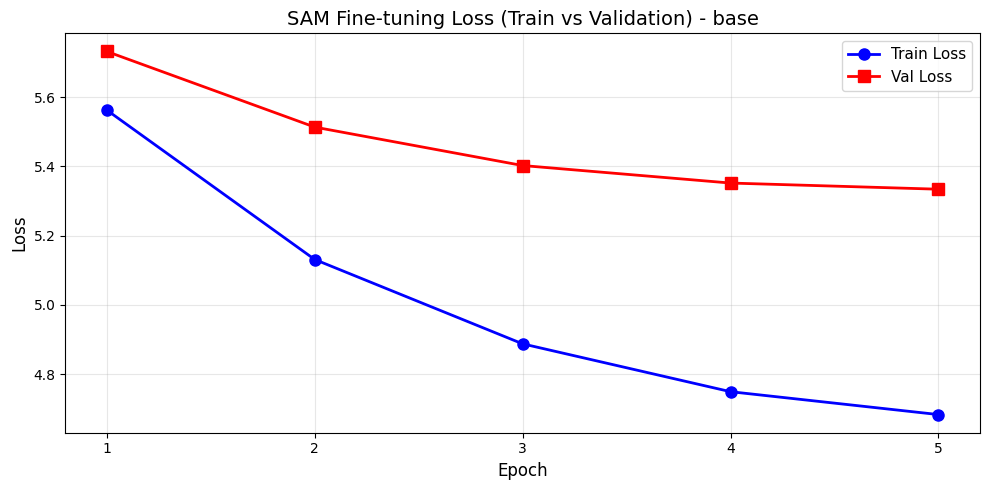


TRAINING SUMMARY
  Total Epochs: 5
  Final Train Loss: 4.6833
  Final Val Loss: 5.3340
  Best Val Loss: 5.3340
  Model: SAM base
  Unfrozen blocks: 1
  Learning rate: 5e-06
  Batch size: 2


In [ ]:
# Run SAM fine-tuning
finetuned_sam, losses_history = train_finetune()

# Plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 5))

epochs_range = range(1, len(losses_history['train']) + 1)
ax.plot(epochs_range, losses_history['train'], 'b-o', label='Train Loss', linewidth=2, markersize=8)
ax.plot(epochs_range, losses_history['val'], 'r-s', label='Val Loss', linewidth=2, markersize=8)

ax.set_title(f"SAM Fine-tuning Loss (Train vs Validation) - {CONFIG['backbone_size']}", fontsize=14)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(epochs_range)

plt.tight_layout()
plt.show()

# Print training summary
print("\n" + "=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)
print(f"  Total Epochs: {len(losses_history['train'])}")
print(f"  Final Train Loss: {losses_history['train'][-1]:.4f}")
print(f"  Final Val Loss: {losses_history['val'][-1]:.4f}")
print(f"  Best Val Loss: {min(losses_history['val']):.4f}")
print(f"  Model: SAM {CONFIG['backbone_size']}")
print(f"  Unfrozen blocks: {FT_CONFIG['unfreeze_last_n_blocks']}")
print(f"  Learning rate: {FT_CONFIG['learning_rate']}")
print(f"  Batch size: {FT_CONFIG['batch_size']}")
print("=" * 70)

EVALUATE FINETUNED MODEL

In [ ]:
def evaluate_model(model, tag='finetuned', use_final_layer=False):
    """
    Evaluate SAM model on the test set.

    Args:
        model: SAM image encoder to evaluate
        tag: Name tag for the evaluation (e.g., 'base', 'finetuned')
        use_final_layer: If True, use final output instead of intermediate layer
                        Should match what was used during training!

    Returns:
        Dictionary with evaluation results and predictions
    """
    print("\n" + "="*60)
    print(f"EVALUATION ({tag.upper()})")
    print("="*60)

    # Determine which layer to use
    layer_idx = None if use_final_layer else CONFIG['feature_layer']
    print(f"Using layer_idx={layer_idx} (None=final output, otherwise layer {CONFIG['feature_layer']})")

    print("\nRunning evaluation on test set...")

    # Load test dataset (use original SPairDataset, not WithSplit)
    dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='test',
        image_size=CONFIG['image_size'],
        max_samples=CONFIG['max_samples']
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch],
            'category': [item['category'] for item in batch]
        }

    dataloader = DataLoader(
        dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn
    )

    extractor = SAMFeatureExtractor(
        model,
        CONFIG['patch_size'],
        CONFIG['device']
    )

    all_preds = []
    all_gts = []
    all_valids = []
    all_cats = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src_img = batch['src_img'].to(CONFIG['device'])
            tgt_img = batch['tgt_img'].to(CONFIG['device'])
            src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
            valid = [v.to(CONFIG['device']) for v in batch['valid']]

            # Extract features using specified layer
            src_feats = extractor.extract(src_img, layer_idx=layer_idx)
            tgt_feats = extractor.extract(tgt_img, layer_idx=layer_idx)

            # Find correspondences
            pred_kps = find_correspondences(src_feats, tgt_feats, src_kps, CONFIG['patch_size'])

            all_preds.extend([p.cpu() for p in pred_kps])
            all_gts.extend([g.cpu() for g in tgt_kps])
            all_valids.extend([v.cpu() for v in valid])
            all_cats.extend(batch['category'])

    # Compute overall PCK metrics (both per-keypoint and per-image)
    pck_overall = compute_pck(
        all_preds,
        all_gts,
        all_valids,
        CONFIG['pck_thresholds'],
        CONFIG['image_size']
    )

    print("\nOverall Results (Per-Keypoint):")
    for threshold, pck in pck_overall['per_keypoint'].items():
        print(f"  {threshold}: {pck:.2f}%")

    print("\nOverall Results (Per-Image):")
    for threshold, pck in pck_overall['per_image'].items():
        print(f"  {threshold}: {pck:.2f}%")

    # Compute per-category PCK metrics
    unique_cats = sorted(set(all_cats))
    pck_by_cat = {cat: {} for cat in unique_cats}

    print(f"\nPer-Category Results (PCK@0.1):")
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        cat_preds = [all_preds[i] for i in cat_indices]
        cat_gts = [all_gts[i] for i in cat_indices]
        cat_valids = [all_valids[i] for i in cat_indices]

        if cat_preds:
            cat_pck = compute_pck(
                cat_preds,
                cat_gts,
                cat_valids,
                CONFIG['pck_thresholds'],
                CONFIG['image_size']
            )
            pck_by_cat[cat] = cat_pck
            print(f"  {cat}: Per-Keypoint = {cat_pck['per_keypoint']['PCK@0.1']:.1f}% | Per-Image = {cat_pck['per_image']['PCK@0.1']:.1f}%")

    return {
        'overall': pck_overall,
        'categories': pck_by_cat,
        'predictions': all_preds,
        'ground_truth': all_gts,
        'valid': all_valids,
        'categories_list': all_cats,
        'dataset': dataset
    }

# Evaluate the fine-tuned SAM model
# IMPORTANT: use_final_layer should match what was used during training
results_finetuned = evaluate_model(
    finetuned_sam,
    tag='finetuned',
    use_final_layer=FT_CONFIG.get('use_final_layer', False)
)


EVALUATION (FINETUNED)
Using layer_idx=None (None=final output, otherwise layer 9)

Running evaluation on test set...
Building annotation cache...
✓ Cached 3497 annotations
✓ Loaded 3497 pairs with annotations (test)
  Skipped 8737 pairs without annotations
✓ Categories: 18 - aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor


Evaluating: 100%|██████████| 875/875 [1:00:15<00:00,  4.13s/it]



Overall Results (Per-Keypoint):
  PCK@0.05: 33.27%
  PCK@0.1: 46.62%
  PCK@0.15: 56.23%
  PCK@0.2: 63.83%

Overall Results (Per-Image):
  PCK@0.05: 1.03%
  PCK@0.1: 3.75%
  PCK@0.15: 8.15%
  PCK@0.2: 13.18%

Per-Category Results (PCK@0.1):
  aeroplane: Per-Keypoint = 42.6% | Per-Image = 3.0%
  bicycle: Per-Keypoint = 32.3% | Per-Image = 0.6%
  bird: Per-Keypoint = 69.2% | Per-Image = 11.5%
  boat: Per-Keypoint = 29.0% | Per-Image = 2.0%
  bottle: Per-Keypoint = 36.4% | Per-Image = 1.8%
  bus: Per-Keypoint = 39.1% | Per-Image = 1.6%
  car: Per-Keypoint = 34.8% | Per-Image = 2.4%
  cat: Per-Keypoint = 60.3% | Per-Image = 2.3%
  chair: Per-Keypoint = 31.5% | Per-Image = 1.0%
  cow: Per-Keypoint = 51.8% | Per-Image = 4.4%
  dog: Per-Keypoint = 43.9% | Per-Image = 0.0%
  horse: Per-Keypoint = 45.6% | Per-Image = 0.0%
  motorbike: Per-Keypoint = 35.5% | Per-Image = 1.5%
  person: Per-Keypoint = 56.7% | Per-Image = 6.8%
  pottedplant: Per-Keypoint = 45.1% | Per-Image = 7.8%
  sheep: Per-Keyp

## 💾 Save Fine-tuned Results to CSV

In [ ]:
# Determine layer name for filename
use_final_layer = FT_CONFIG.get('use_final_layer', False)
if use_final_layer:
    layer_name = "final"
else:
    layer_name = f"layer{CONFIG['feature_layer']}"

# Determine image size
image_size = CONFIG['image_size']

# Create results directory if it doesn't exist
results_dir = DRIVE_ROOT / 'results'
results_dir.mkdir(exist_ok=True)

# File paths
overall_csv = results_dir / f"sam_finetuned_{layer_name}_{image_size}_overall.csv"
categories_csv = results_dir / f"sam_finetuned_{layer_name}_{image_size}_categories.csv"

print(f"\n{'='*70}")
print("SAVING FINE-TUNED RESULTS")
print(f"{'='*70}")
print(f"Layer: {layer_name}")
print(f"Image size: {image_size}px")

# ============================================================================
# 1. Save Overall Results (both per-keypoint and per-image)
# ============================================================================
rows_overall = []

# Per-Keypoint metrics
for threshold in CONFIG['pck_thresholds']:
    pck_kp = results_finetuned['overall']['per_keypoint'][f'PCK@{threshold}']
    rows_overall.append({
        'Threshold': threshold,
        'Metric': 'per_keypoint',
        'PCK': pck_kp
    })

# Per-Image metrics
if 'per_image' in results_finetuned['overall']:
    for threshold in CONFIG['pck_thresholds']:
        pck_img = results_finetuned['overall']['per_image'][f'PCK@{threshold}']
        rows_overall.append({
            'Threshold': threshold,
            'Metric': 'per_image',
            'PCK': pck_img
        })

df_overall = pd.DataFrame(rows_overall)
df_overall.to_csv(overall_csv, index=False, float_format='%.2f')
print(f"\n✓ Saved overall results: {overall_csv.name}")
print(df_overall.to_string(index=False, float_format='%.2f'))

# ============================================================================
# 2. Save Per-Category Results
# ============================================================================
rows_categories = []

for cat in sorted(results_finetuned['categories'].keys()):
    cat_data = {'Category': cat}

    # Per-Keypoint metrics
    for threshold in CONFIG['pck_thresholds']:
        col_name_kp = f'PCK@{threshold}_keypoint'
        pck_kp = results_finetuned['categories'][cat]['per_keypoint'].get(f'PCK@{threshold}', 0)
        cat_data[col_name_kp] = pck_kp

    # Per-Image metrics (if available)
    if 'per_image' in results_finetuned['categories'][cat]:
        for threshold in CONFIG['pck_thresholds']:
            col_name_img = f'PCK@{threshold}_image'
            pck_img = results_finetuned['categories'][cat]['per_image'].get(f'PCK@{threshold}', 0)
            cat_data[col_name_img] = pck_img

    rows_categories.append(cat_data)

df_categories = pd.DataFrame(rows_categories)
df_categories.to_csv(categories_csv, index=False, float_format='%.1f')
print(f"\n✓ Saved per-category results: {categories_csv.name}")
print(f"  {len(df_categories)} categories saved")

print(f"\n{'='*70}")
print("FILES SAVED:")
print(f"{'='*70}")
print(f"  {overall_csv}")
print(f"  {categories_csv}")
print(f"{'='*70}\n")


SAVING FINE-TUNED RESULTS
Layer: final
Image size: 512px

✓ Saved overall results: sam_finetuned_final_512_overall.csv
 Threshold       Metric   PCK
      0.05 per_keypoint 33.27
      0.10 per_keypoint 46.62
      0.15 per_keypoint 56.23
      0.20 per_keypoint 63.83
      0.05    per_image  1.03
      0.10    per_image  3.75
      0.15    per_image  8.15
      0.20    per_image 13.18

✓ Saved per-category results: sam_finetuned_final_512_categories.csv
  18 categories saved

FILES SAVED:
  /content/drive/MyDrive/SemanticCorrespondence/results/sam_finetuned_final_512_overall.csv
  /content/drive/MyDrive/SemanticCorrespondence/results/sam_finetuned_final_512_categories.csv



COMPARISON: BASE vs FINETUNED

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

print("="*60)
print("COMPARISON FROM SAVED CSV FILES")
print("="*60)

# Define paths to CSV files
results_dir = DRIVE_ROOT / 'results'

# Baseline files - try both combined and separate formats
base_overall_csv = results_dir / "sam_base_layer9_512_overall.csv"
base_categories_csv = results_dir / "sam_base_layer9_512_categories.csv"

# Alternative format: separate files for per-keypoint and per-image
base_overall_kp_csv = results_dir / "sam_base_layer9_overall_per_keypoint.csv"
base_overall_img_csv = results_dir / "sam_base_layer9_overall_per_image.csv"
base_categories_kp_csv = results_dir / "sam_base_layer9_categories_per_keypoint.csv"
base_categories_img_csv = results_dir / "sam_base_layer9_categories_per_image.csv"

# Fine-tuned files
ft_overall_csv = results_dir / "sam_finetuned_final_512_overall.csv"
ft_categories_csv = results_dir / "sam_finetuned_final_512_categories.csv"

# Check which baseline format exists
use_separate_baseline = False
if not base_overall_csv.exists() and base_overall_kp_csv.exists():
    use_separate_baseline = True
    print("ℹ️  Using separate baseline files (per-keypoint and per-image in different files)\n")

# Check if all required files exist
missing_files = []
if use_separate_baseline:
    for f, name in [(base_overall_kp_csv, "Baseline overall per-keypoint"),
                    (base_overall_img_csv, "Baseline overall per-image"),
                    (base_categories_kp_csv, "Baseline categories per-keypoint"),
                    (base_categories_img_csv, "Baseline categories per-image"),
                    (ft_overall_csv, "Fine-tuned overall"),
                    (ft_categories_csv, "Fine-tuned categories")]:
        if not f.exists():
            missing_files.append(f"{name}: {f}")
else:
    for f, name in [(base_overall_csv, "Baseline overall"),
                    (base_categories_csv, "Baseline categories"),
                    (ft_overall_csv, "Fine-tuned overall"),
                    (ft_categories_csv, "Fine-tuned categories")]:
        if not f.exists():
            missing_files.append(f"{name}: {f}")

if missing_files:
    print("\n⚠️  Missing files:")
    for f in missing_files:
        print(f"  {f}")
    print("\nPlease run the evaluation cells first to generate these files.")
else:
    print("\n✓ All CSV files found. Loading data...\n")

    # Load baseline results (support both formats)
    if use_separate_baseline:
        # Separate files format
        base_overall_kp_df = pd.read_csv(base_overall_kp_csv)
        base_overall_img_df = pd.read_csv(base_overall_img_csv)

        # Combine into single dataframe with Type column
        base_overall_kp_df['Type'] = 'per_keypoint'
        base_overall_img_df['Type'] = 'per_image'
        base_overall_df = pd.concat([base_overall_kp_df, base_overall_img_df], ignore_index=True)

        base_categories_kp_df = pd.read_csv(base_categories_kp_csv)
        base_categories_img_df = pd.read_csv(base_categories_img_csv)

        # Combine into single dataframe with Type column
        base_categories_kp_df['Type'] = 'per_keypoint'
        base_categories_img_df['Type'] = 'per_image'
        base_categories_df = pd.concat([base_categories_kp_df, base_categories_img_df], ignore_index=True)
    else:
        # Combined format (with Type column already)
        base_overall_df = pd.read_csv(base_overall_csv)
        base_categories_df = pd.read_csv(base_categories_csv)

    # Load fine-tuned results
    ft_overall_df = pd.read_csv(ft_overall_csv)
    ft_categories_df = pd.read_csv(ft_categories_csv)

    print("="*60)
    print("OVERALL RESULTS COMPARISON")
    print("="*60)

    # Separate per-keypoint and per-image results
    if 'Type' in base_overall_df.columns:
        per_keypoint_base = base_overall_df[base_overall_df['Type'] == 'per_keypoint']
        per_keypoint_ft = ft_overall_df[ft_overall_df['Type'] == 'per_keypoint']
        per_image_base = base_overall_df[base_overall_df['Type'] == 'per_image']
        per_image_ft = ft_overall_df[ft_overall_df['Type'] == 'per_image']
    else:
        # If no Type column, assume all are per-keypoint
        per_keypoint_base = base_overall_df
        per_keypoint_ft = ft_overall_df
        per_image_base = pd.DataFrame()
        per_image_ft = pd.DataFrame()

    # Overall per-keypoint comparison
    print("\n📊 Per-Keypoint PCK:")
    print(f"{'Threshold':<12} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
    print("-" * 60)

    for idx, row in per_keypoint_base.iterrows():
        threshold = row['Threshold']
        base_val = row['PCK']
        ft_val = per_keypoint_ft.loc[per_keypoint_ft['Threshold'] == threshold, 'PCK'].values[0]
        improvement = ft_val - base_val

        print(f"{threshold:<12} {base_val:>10.2f}%  {ft_val:>10.2f}%  {improvement:>+10.2f}%")

    # Overall per-image comparison
    if not per_image_base.empty and not per_image_ft.empty:
        print("\n🖼️  Per-Image PCK:")
        print(f"{'Threshold':<12} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
        print("-" * 60)

        for idx, row in per_image_base.iterrows():
            threshold = row['Threshold']
            base_val = row['PCK']
            ft_val = per_image_ft.loc[per_image_ft['Threshold'] == threshold, 'PCK'].values[0]
            improvement = ft_val - base_val

            print(f"{threshold:<12} {base_val:>10.2f}%  {ft_val:>10.2f}%  {improvement:>+10.2f}%")

    print("\n" + "="*60)
    print("PER-CATEGORY RESULTS (PCK@0.1)")
    print("="*60)

    # Detect format: check if Threshold column exists
    has_threshold_col = 'Threshold' in base_categories_df.columns
    has_type_col = 'Type' in base_categories_df.columns

    # Separate per-keypoint and per-image for categories
    if has_type_col:
        # Per-keypoint categories
        print(f"\n📊 Per-Keypoint:")
        print(f"{'Category':<15} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
        print("-" * 60)

        for cat in sorted(base_categories_df['Category'].unique()):
            if has_threshold_col:
                base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                                   (base_categories_df['Threshold'] == 'PCK@0.1') &
                                                   (base_categories_df['Type'] == 'per_keypoint')]
                ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                               (ft_categories_df['Threshold'] == 'PCK@0.1') &
                                               (ft_categories_df['Type'] == 'per_keypoint')]
            else:
                # No Threshold column, assume all rows are PCK@0.1
                base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                                   (base_categories_df['Type'] == 'per_keypoint')]
                ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                               (ft_categories_df['Type'] == 'per_keypoint')]

            if not base_cat_row.empty and not ft_cat_row.empty:
                base_val = base_cat_row['PCK'].values[0]
                ft_val = ft_cat_row['PCK'].values[0]
                improvement = ft_val - base_val

                print(f"{cat:<15} {base_val:>10.1f}%  {ft_val:>10.1f}%  {improvement:>+10.1f}%")

        # Per-image categories
        print(f"\n🖼️  Per-Image:")
        print(f"{'Category':<15} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
        print("-" * 60)

        for cat in sorted(base_categories_df['Category'].unique()):
            if has_threshold_col:
                base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                                   (base_categories_df['Threshold'] == 'PCK@0.1') &
                                                   (base_categories_df['Type'] == 'per_image')]
                ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                               (ft_categories_df['Threshold'] == 'PCK@0.1') &
                                               (ft_categories_df['Type'] == 'per_image')]
            else:
                # No Threshold column, assume all rows are PCK@0.1
                base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                                   (base_categories_df['Type'] == 'per_image')]
                ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                               (ft_categories_df['Type'] == 'per_image')]

            if not base_cat_row.empty and not ft_cat_row.empty:
                base_val = base_cat_row['PCK'].values[0]
                ft_val = ft_cat_row['PCK'].values[0]
                improvement = ft_val - base_val

                print(f"{cat:<15} {base_val:>10.1f}%  {ft_val:>10.1f}%  {improvement:>+10.1f}%")
    else:
        # Old format without Type column
        print(f"\n{'Category':<15} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
        print("-" * 60)

        for cat in sorted(base_categories_df['Category'].unique()):
            if has_threshold_col:
                base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                                   (base_categories_df['Threshold'] == 'PCK@0.1')]
                ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                               (ft_categories_df['Threshold'] == 'PCK@0.1')]
            else:
                # No Threshold column, assume all rows are PCK@0.1
                base_cat_row = base_categories_df[base_categories_df['Category'] == cat]
                ft_cat_row = ft_categories_df[ft_categories_df['Category'] == cat]

            if not base_cat_row.empty and not ft_cat_row.empty:
                base_val = base_cat_row['PCK'].values[0]
                ft_val = ft_cat_row['PCK'].values[0]
                improvement = ft_val - base_val

                print(f"{cat:<15} {base_val:>10.1f}%  {ft_val:>10.1f}%  {improvement:>+10.1f}%")

    # Visualization: Bar chart comparison
    print("\n" + "="*60)
    print("GENERATING COMPARISON PLOTS")
    print("="*60)

    # Create figure with more subplots for per-keypoint and per-image
    if not per_image_base.empty and not per_image_ft.empty:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Overall PCK per-keypoint
        ax1 = axes[0, 0]
        thresholds_kp = per_keypoint_base['Threshold'].values
        base_vals_kp = per_keypoint_base['PCK'].values
        ft_vals_kp = per_keypoint_ft['PCK'].values

        x = np.arange(len(thresholds_kp))
        width = 0.35

        ax1.bar(x - width/2, base_vals_kp, width, label='Baseline', alpha=0.8, color='steelblue')
        ax1.bar(x + width/2, ft_vals_kp, width, label='Fine-tuned', alpha=0.8, color='darkorange')

        ax1.set_xlabel('PCK Threshold', fontsize=12)
        ax1.set_ylabel('PCK (%)', fontsize=12)
        ax1.set_title('Overall Per-Keypoint PCK', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(thresholds_kp)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)

        # Plot 2: Overall PCK per-image
        ax2 = axes[0, 1]
        thresholds_img = per_image_base['Threshold'].values
        base_vals_img = per_image_base['PCK'].values
        ft_vals_img = per_image_ft['PCK'].values

        x2 = np.arange(len(thresholds_img))

        ax2.bar(x2 - width/2, base_vals_img, width, label='Baseline', alpha=0.8, color='steelblue')
        ax2.bar(x2 + width/2, ft_vals_img, width, label='Fine-tuned', alpha=0.8, color='darkorange')

        ax2.set_xlabel('PCK Threshold', fontsize=12)
        ax2.set_ylabel('PCK (%)', fontsize=12)
        ax2.set_title('Overall Per-Image PCK', fontsize=14, fontweight='bold')
        ax2.set_xticks(x2)
        ax2.set_xticklabels(thresholds_img)
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        # Plot 3: Per-category PCK@0.1 (per-keypoint)
        ax3 = axes[1, 0]
        categories_kp = []
        base_cat_vals_kp = []
        ft_cat_vals_kp = []

        for cat in sorted(base_categories_df['Category'].unique()):
            base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                               (base_categories_df['Threshold'] == 'PCK@0.1') &
                                               (base_categories_df['Type'] == 'per_keypoint')]
            ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                           (ft_categories_df['Threshold'] == 'PCK@0.1') &
                                           (ft_categories_df['Type'] == 'per_keypoint')]

            if not base_cat_row.empty and not ft_cat_row.empty:
                categories_kp.append(cat)
                base_cat_vals_kp.append(base_cat_row['PCK'].values[0])
                ft_cat_vals_kp.append(ft_cat_row['PCK'].values[0])

        x3 = np.arange(len(categories_kp))

        ax3.bar(x3 - width/2, base_cat_vals_kp, width, label='Baseline', alpha=0.8, color='steelblue')
        ax3.bar(x3 + width/2, ft_cat_vals_kp, width, label='Fine-tuned', alpha=0.8, color='darkorange')

        ax3.set_xlabel('Category', fontsize=12)
        ax3.set_ylabel('PCK@0.1 (%)', fontsize=12)
        ax3.set_title('Per-Category Per-Keypoint PCK@0.1', fontsize=14, fontweight='bold')
        ax3.set_xticks(x3)
        ax3.set_xticklabels(categories_kp, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)

        # Plot 4: Per-category PCK@0.1 (per-image)
        ax4 = axes[1, 1]
        categories_img = []
        base_cat_vals_img = []
        ft_cat_vals_img = []

        for cat in sorted(base_categories_df['Category'].unique()):
            base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                               (base_categories_df['Threshold'] == 'PCK@0.1') &
                                               (base_categories_df['Type'] == 'per_image')]
            ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                           (ft_categories_df['Threshold'] == 'PCK@0.1') &
                                           (ft_categories_df['Type'] == 'per_image')]

            if not base_cat_row.empty and not ft_cat_row.empty:
                categories_img.append(cat)
                base_cat_vals_img.append(base_cat_row['PCK'].values[0])
                ft_cat_vals_img.append(ft_cat_row['PCK'].values[0])

        x4 = np.arange(len(categories_img))

        ax4.bar(x4 - width/2, base_cat_vals_img, width, label='Baseline', alpha=0.8, color='steelblue')
        ax4.bar(x4 + width/2, ft_cat_vals_img, width, label='Fine-tuned', alpha=0.8, color='darkorange')

        ax4.set_xlabel('Category', fontsize=12)
        ax4.set_ylabel('PCK@0.1 (%)', fontsize=12)
        ax4.set_title('Per-Category Per-Image PCK@0.1', fontsize=14, fontweight='bold')
        ax4.set_xticks(x4)
        ax4.set_xticklabels(categories_img, rotation=45, ha='right')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        # Fallback to 2 plots if no per-image data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Overall PCK across thresholds
        thresholds = per_keypoint_base['Threshold'].values
        base_vals = per_keypoint_base['PCK'].values
        ft_vals = per_keypoint_ft['PCK'].values

        x = np.arange(len(thresholds))
        width = 0.35

        ax1.bar(x - width/2, base_vals, width, label='Baseline', alpha=0.8, color='steelblue')
        ax1.bar(x + width/2, ft_vals, width, label='Fine-tuned', alpha=0.8, color='darkorange')

        ax1.set_xlabel('PCK Threshold', fontsize=12)
        ax1.set_ylabel('PCK (%)', fontsize=12)
        ax1.set_title('Overall PCK: Baseline vs Fine-tuned', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(thresholds)
        ax1.legend()
        ax1.grid(axis='y', alpha=0.3)

        # Per-category PCK@0.1
        categories = []
        base_cat_vals = []
        ft_cat_vals = []

        for cat in sorted(base_categories_df['Category'].unique()):
            base_cat_row = base_categories_df[(base_categories_df['Category'] == cat) &
                                               (base_categories_df['Threshold'] == 'PCK@0.1')]
            ft_cat_row = ft_categories_df[(ft_categories_df['Category'] == cat) &
                                           (ft_categories_df['Threshold'] == 'PCK@0.1')]

            if not base_cat_row.empty and not ft_cat_row.empty:
                categories.append(cat)
                base_cat_vals.append(base_cat_row['PCK'].values[0])
                ft_cat_vals.append(ft_cat_row['PCK'].values[0])

        x2 = np.arange(len(categories))

        ax2.bar(x2 - width/2, base_cat_vals, width, label='Baseline', alpha=0.8, color='steelblue')
        ax2.bar(x2 + width/2, ft_cat_vals, width, label='Fine-tuned', alpha=0.8, color='darkorange')

        ax2.set_xlabel('Category', fontsize=12)
        ax2.set_ylabel('PCK@0.1 (%)', fontsize=12)
        ax2.set_title('Per-Category PCK@0.1: Baseline vs Fine-tuned', fontsize=14, fontweight='bold')
        ax2.set_xticks(x2)
        ax2.set_xticklabels(categories, rotation=45, ha='right')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Extract PCK@0.1 values for summary
    base_pck_01_kp = per_keypoint_base[per_keypoint_base['Threshold'] == 'PCK@0.1']['PCK'].values[0]
    ft_pck_01_kp = per_keypoint_ft[per_keypoint_ft['Threshold'] == 'PCK@0.1']['PCK'].values[0]

    print("\n✓ Comparison complete!")
    print(f"\nSummary (PCK@0.1 Per-Keypoint):")
    print(f"  Baseline:     {base_pck_01_kp:.2f}%")
    print(f"  Fine-tuned:   {ft_pck_01_kp:.2f}%")
    print(f"  Improvement:  {ft_pck_01_kp - base_pck_01_kp:+.2f}%")

    if not per_image_base.empty and not per_image_ft.empty:
        base_pck_01_img = per_image_base[per_image_base['Threshold'] == 'PCK@0.1']['PCK'].values[0]
        ft_pck_01_img = per_image_ft[per_image_ft['Threshold'] == 'PCK@0.1']['PCK'].values[0]

        print(f"\nSummary (PCK@0.1 Per-Image):")
        print(f"  Baseline:     {base_pck_01_img:.2f}%")
        print(f"  Fine-tuned:   {ft_pck_01_img:.2f}%")
        print(f"  Improvement:  {ft_pck_01_img - base_pck_01_img:+.2f}%")

# COMPARISON FROM SAVED FILES: BASE vs FINE-TUNED

Load both baseline and fine-tuned results from CSV files and compare them.

COMPARISON FROM SAVED CSV FILES

✓ All CSV files found. Loading data...

OVERALL RESULTS COMPARISON

📊 Per-Keypoint PCK:
Threshold    Baseline     Fine-tuned   Improvement 
------------------------------------------------------------
0.05              19.93%       33.27%      +13.34%
0.1               31.68%       46.62%      +14.94%
0.15              41.00%       56.23%      +15.23%
0.2               49.59%       63.83%      +14.24%

🖼️  Per-Image PCK:
Threshold    Baseline     Fine-tuned   Improvement 
------------------------------------------------------------
0.05               0.29%        1.03%       +0.74%
0.1                1.00%        3.75%       +2.75%
0.15               2.14%        8.15%       +6.01%
0.2                4.00%       13.18%       +9.18%

PER-CATEGORY RESULTS (PCK@0.1)

📊 Per-Keypoint:
Category        Baseline     Fine-tuned   Improvement 
------------------------------------------------------------
aeroplane             31.1%        42.6%       +11.5%
bicycl

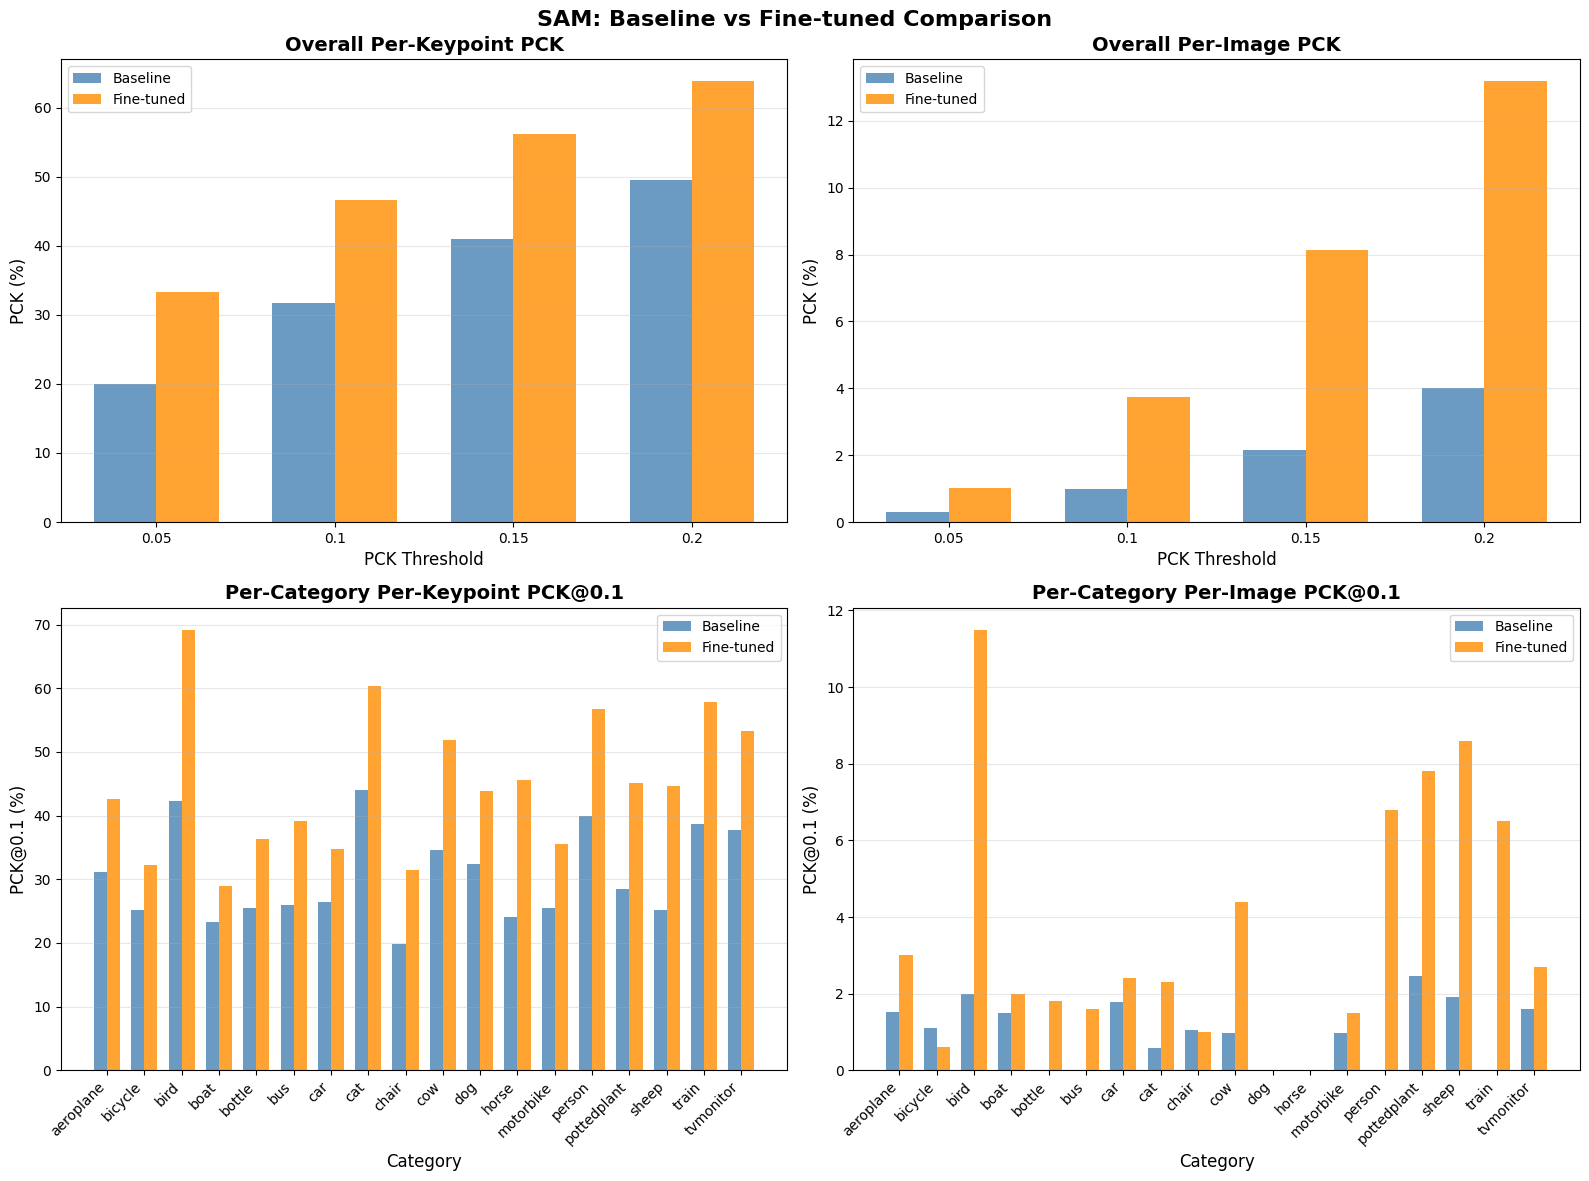


SUMMARY

PCK@0.1 Per-Keypoint: 31.68% → 46.62% (+14.94%)
PCK@0.1 Per-Image:    1.00% → 3.75% (+2.75%)

✓ Comparison complete!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

print("="*60)
print("COMPARISON FROM SAVED CSV FILES")
print("="*60)

# Define paths to CSV files
results_dir = DRIVE_ROOT / 'results'

# Baseline files (separate per-keypoint and per-image)
base_overall_kp_csv = results_dir / "sam_base_layer9_overall_per_keypoint.csv"
base_overall_img_csv = results_dir / "sam_base_layer9_overall_per_image.csv"
base_categories_kp_csv = results_dir / "sam_base_layer9_categories_per_keypoint.csv"
base_categories_img_csv = results_dir / "sam_base_layer9_categories_per_image.csv"

# Fine-tuned files
ft_overall_csv = results_dir / "sam_finetuned_final_512_overall.csv"
ft_categories_csv = results_dir / "sam_finetuned_final_512_categories.csv"

# Check if all files exist
missing_files = []
for f, name in [(base_overall_kp_csv, "Baseline overall per-keypoint"),
                (base_overall_img_csv, "Baseline overall per-image"),
                (base_categories_kp_csv, "Baseline categories per-keypoint"),
                (base_categories_img_csv, "Baseline categories per-image"),
                (ft_overall_csv, "Fine-tuned overall"),
                (ft_categories_csv, "Fine-tuned categories")]:
    if not f.exists():
        missing_files.append(f"{name}: {f}")

if missing_files:
    print("\n⚠️  Missing files:")
    for f in missing_files:
        print(f"  {f}")
    print("\nPlease run the evaluation cells first to generate these files.")
else:
    print("\n✓ All CSV files found. Loading data...\n")

    # Load baseline results
    # Overall: Threshold, PCK_PerKeypoint / PCK_PerImage
    base_overall_kp_df = pd.read_csv(base_overall_kp_csv)
    base_overall_img_df = pd.read_csv(base_overall_img_csv)

    # Categories: Category, PCK@0.05, PCK@0.1, PCK@0.15, PCK@0.2
    # Filter out the "AVERAGE" row from baseline categories
    base_categories_kp_df = pd.read_csv(base_categories_kp_csv)
    base_categories_kp_df = base_categories_kp_df[base_categories_kp_df['Category'] != 'AVERAGE']

    base_categories_img_df = pd.read_csv(base_categories_img_csv)
    base_categories_img_df = base_categories_img_df[base_categories_img_df['Category'] != 'AVERAGE']

    # Load fine-tuned results
    # Overall: Threshold, Metric, PCK
    ft_overall_df = pd.read_csv(ft_overall_csv)

    # Categories: Category, PCK@0.05_keypoint, PCK@0.1_keypoint, ..., PCK@0.05_image, ...
    ft_categories_df = pd.read_csv(ft_categories_csv)

    # Extract per-keypoint and per-image from fine-tuned overall
    ft_overall_kp_df = ft_overall_df[ft_overall_df['Metric'] == 'per_keypoint'].copy()
    ft_overall_img_df = ft_overall_df[ft_overall_df['Metric'] == 'per_image'].copy()

    print("="*60)
    print("OVERALL RESULTS COMPARISON")
    print("="*60)

    # Overall per-keypoint comparison
    print("\n📊 Per-Keypoint PCK:")
    print(f"{'Threshold':<12} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
    print("-" * 60)

    for idx, row in base_overall_kp_df.iterrows():
        threshold = row['Threshold']
        base_val = row['PCK_PerKeypoint']
        ft_val = ft_overall_kp_df[ft_overall_kp_df['Threshold'] == threshold]['PCK'].values[0]
        improvement = ft_val - base_val

        print(f"{threshold:<12} {base_val:>10.2f}%  {ft_val:>10.2f}%  {improvement:>+10.2f}%")

    # Overall per-image comparison
    print("\n🖼️  Per-Image PCK:")
    print(f"{'Threshold':<12} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
    print("-" * 60)

    for idx, row in base_overall_img_df.iterrows():
        threshold = row['Threshold']
        base_val = row['PCK_PerImage']
        ft_val = ft_overall_img_df[ft_overall_img_df['Threshold'] == threshold]['PCK'].values[0]
        improvement = ft_val - base_val

        print(f"{threshold:<12} {base_val:>10.2f}%  {ft_val:>10.2f}%  {improvement:>+10.2f}%")

    print("\n" + "="*60)
    print("PER-CATEGORY RESULTS (PCK@0.1)")
    print("="*60)

    # Per-keypoint categories
    print(f"\n📊 Per-Keypoint:")
    print(f"{'Category':<15} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
    print("-" * 60)

    for idx, row in base_categories_kp_df.iterrows():
        cat = row['Category']
        base_val = row['PCK@0.1']
        ft_val = ft_categories_df[ft_categories_df['Category'] == cat]['PCK@0.1_keypoint'].values[0]
        improvement = ft_val - base_val

        print(f"{cat:<15} {base_val:>10.1f}%  {ft_val:>10.1f}%  {improvement:>+10.1f}%")

    # Per-image categories
    print(f"\n🖼️  Per-Image:")
    print(f"{'Category':<15} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
    print("-" * 60)

    for idx, row in base_categories_img_df.iterrows():
        cat = row['Category']
        base_val = row['PCK@0.1']
        ft_val = ft_categories_df[ft_categories_df['Category'] == cat]['PCK@0.1_image'].values[0]
        improvement = ft_val - base_val

        print(f"{cat:<15} {base_val:>10.1f}%  {ft_val:>10.1f}%  {improvement:>+10.1f}%")

    # Visualization: Bar chart comparison
    print("\n" + "="*60)
    print("GENERATING COMPARISON PLOTS")
    print("="*60)

    # Create figure with 4 subplots (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('SAM: Baseline vs Fine-tuned Comparison', fontsize=16, fontweight='bold')

    width = 0.35

    # Plot 1: Overall PCK - Per-Keypoint
    ax1 = axes[0, 0]
    thresholds_kp = base_overall_kp_df['Threshold'].values
    base_vals_kp = base_overall_kp_df['PCK_PerKeypoint'].values
    ft_vals_kp = ft_overall_kp_df['PCK'].values

    x = np.arange(len(thresholds_kp))

    ax1.bar(x - width/2, base_vals_kp, width, label='Baseline', alpha=0.8, color='steelblue')
    ax1.bar(x + width/2, ft_vals_kp, width, label='Fine-tuned', alpha=0.8, color='darkorange')

    ax1.set_xlabel('PCK Threshold', fontsize=12)
    ax1.set_ylabel('PCK (%)', fontsize=12)
    ax1.set_title('Overall Per-Keypoint PCK', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(thresholds_kp)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Overall PCK - Per-Image
    ax2 = axes[0, 1]
    thresholds_img = base_overall_img_df['Threshold'].values
    base_vals_img = base_overall_img_df['PCK_PerImage'].values
    ft_vals_img = ft_overall_img_df['PCK'].values

    x2 = np.arange(len(thresholds_img))

    ax2.bar(x2 - width/2, base_vals_img, width, label='Baseline', alpha=0.8, color='steelblue')
    ax2.bar(x2 + width/2, ft_vals_img, width, label='Fine-tuned', alpha=0.8, color='darkorange')

    ax2.set_xlabel('PCK Threshold', fontsize=12)
    ax2.set_ylabel('PCK (%)', fontsize=12)
    ax2.set_title('Overall Per-Image PCK', fontsize=14, fontweight='bold')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(thresholds_img)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Per-Category PCK@0.1 - Per-Keypoint
    ax3 = axes[1, 0]
    categories = base_categories_kp_df['Category'].values
    base_cat_kp_vals = base_categories_kp_df['PCK@0.1'].values
    ft_cat_kp_vals = [ft_categories_df[ft_categories_df['Category'] == cat]['PCK@0.1_keypoint'].values[0]
                      for cat in categories]

    x3 = np.arange(len(categories))

    ax3.bar(x3 - width/2, base_cat_kp_vals, width, label='Baseline', alpha=0.8, color='steelblue')
    ax3.bar(x3 + width/2, ft_cat_kp_vals, width, label='Fine-tuned', alpha=0.8, color='darkorange')

    ax3.set_xlabel('Category', fontsize=12)
    ax3.set_ylabel('PCK@0.1 (%)', fontsize=12)
    ax3.set_title('Per-Category Per-Keypoint PCK@0.1', fontsize=14, fontweight='bold')
    ax3.set_xticks(x3)
    ax3.set_xticklabels(categories, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # Plot 4: Per-Category PCK@0.1 - Per-Image
    ax4 = axes[1, 1]
    base_cat_img_vals = base_categories_img_df['PCK@0.1'].values
    ft_cat_img_vals = [ft_categories_df[ft_categories_df['Category'] == cat]['PCK@0.1_image'].values[0]
                       for cat in categories]

    x4 = np.arange(len(categories))

    ax4.bar(x4 - width/2, base_cat_img_vals, width, label='Baseline', alpha=0.8, color='steelblue')
    ax4.bar(x4 + width/2, ft_cat_img_vals, width, label='Fine-tuned', alpha=0.8, color='darkorange')

    ax4.set_xlabel('Category', fontsize=12)
    ax4.set_ylabel('PCK@0.1 (%)', fontsize=12)
    ax4.set_title('Per-Category Per-Image PCK@0.1', fontsize=14, fontweight='bold')
    ax4.set_xticks(x4)
    ax4.set_xticklabels(categories, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)

    # PCK@0.1 improvements
    base_kp_01 = base_overall_kp_df[base_overall_kp_df['Threshold'] == 0.1]['PCK_PerKeypoint'].values[0]
    ft_kp_01 = ft_overall_kp_df[ft_overall_kp_df['Threshold'] == 0.1]['PCK'].values[0]
    base_img_01 = base_overall_img_df[base_overall_img_df['Threshold'] == 0.1]['PCK_PerImage'].values[0]
    ft_img_01 = ft_overall_img_df[ft_overall_img_df['Threshold'] == 0.1]['PCK'].values[0]

    print(f"\nPCK@0.1 Per-Keypoint: {base_kp_01:.2f}% → {ft_kp_01:.2f}% ({ft_kp_01-base_kp_01:+.2f}%)")
    print(f"PCK@0.1 Per-Image:    {base_img_01:.2f}% → {ft_img_01:.2f}% ({ft_img_01-base_img_01:+.2f}%)")

    print("\n✓ Comparison complete!")

## 3) Window soft-argmax
Window soft-argmax will be used instead of plain argmax. This should make the prediction more robust to noisy similarity maps. Then, this upgrade will be evaluated using PCK with different thresholds.

## Window Soft-Argmax Configuration

We'll replace the hard argmax with a two-stage approach:
1. **Coarse localization**: Use argmax to find the peak
2. **Refinement**: Apply soft-argmax in a small window around the peak

This should make predictions more robust to noisy similarity maps by:
- Providing sub-pixel precision
- Reducing sensitivity to individual noisy pixels
- Limiting the refinement to a local neighborhood

## Load Fine-Tuned Model for Soft-Argmax Testing

Before testing soft-argmax, we need to load the fine-tuned model from the latest checkpoint.

In [ ]:
# =============================================================================
# LOAD FINE-TUNED MODEL FOR SOFT-ARGMAX TESTING
# =============================================================================

# Define checkpoint directory within CLEAN folder structure
checkpoint_dir = DRIVE_ROOT / 'SemanticCorrespondence' / 'checkpoint'

# Find the most recent FINAL checkpoint
final_checkpoints = sorted(
    checkpoint_dir.glob("sam_finetuned_FINAL_*.pth"),
    key=lambda x: x.stat().st_mtime,
    reverse=True
)

if not final_checkpoints:
    raise FileNotFoundError(f"No FINAL checkpoints found in {checkpoint_dir}")

checkpoint_path = final_checkpoints[0]
print(f"Loading fine-tuned model from: {checkpoint_path.name}")

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=CONFIG['device'], weights_only=False)

# Create fresh model with same architecture
finetuned_sam = load_sam(CONFIG['backbone_size'], CONFIG['device'])

# Load fine-tuned weights
finetuned_sam.load_state_dict(checkpoint['model_state_dict'])

print(f"✓ Fine-tuned model loaded successfully!")
print(f"\nCheckpoint info:")
print(f"  Timestamp: {checkpoint.get('timestamp', 'N/A')}")
if 'best_val_loss' in checkpoint:
    print(f"  Best validation loss: {checkpoint['best_val_loss']:.4f}")
if 'train_losses' in checkpoint:
    print(f"  Training epochs: {len(checkpoint['train_losses'])}")

Loading fine-tuned model from: sam_finetuned_FINAL_20260110_154348.pth
✓ Checkpoint found: sam_vit_b_01ec64.pth
Loading SAM base (vit_b)...
✓ SAM image encoder loaded
✓ Fine-tuned model loaded successfully!

Checkpoint info:
  Timestamp: 20260110_154348
  Best validation loss: 4.2224
  Training epochs: 5


In [ ]:
# =============================================================================
# WINDOW SOFT-ARGMAX CONFIGURATION
# =============================================================================

SOFTARGMAX_CONFIG = {
    'window_size': 9,        # Size of the window around the peak (try 3, 5, 7, 9)
    'temperature': 0.05,     # Temperature for softmax (try 0.05, 0.1, 0.2, 0.5)
}

print("Window Soft-Argmax Configuration:")
for k, v in SOFTARGMAX_CONFIG.items():
    print(f"  {k}: {v}")

Window Soft-Argmax Configuration:
  window_size: 9
  temperature: 0.05


## Window Soft-Argmax Implementation

The core function that applies soft-argmax within a window around the peak location.

In [ ]:
def window_soft_argmax(similarity_map, window_size=5, temperature=0.1):
    """
    Apply soft-argmax within a window around the peak location.

    This is a two-stage approach:
    1. Find the peak using argmax (coarse localization)
    2. Extract a window around the peak
    3. Apply soft-argmax within the window (fine refinement)

    Args:
        similarity_map: [H, W] tensor of similarity scores
        window_size: Size of the window around peak (e.g., 5 means 5x5)
        temperature: Softmax temperature (lower = sharper distribution)

    Returns:
        (x, y): Refined coordinates in grid space (can be sub-pixel!)

    Mathematical Formulation:
    --------------------------
    Given similarity map S and window W centered at peak:

    1. Compute softmax weights:
       w_i = exp(S_i / tau) / sum(exp(S_j / tau)) for j in W

    2. Compute weighted position:
       x_refined = sum(w_i * x_i) for i in W
       y_refined = sum(w_i * y_i) for i in W
    """
    H, W = similarity_map.shape
    device = similarity_map.device

    # =========================================================================
    # STEP 1: Find the peak location using argmax (coarse localization)
    # =========================================================================
    flat_idx = torch.argmax(similarity_map)
    peak_y = flat_idx // W  # Row index
    peak_x = flat_idx % W   # Column index

    # =========================================================================
    # STEP 2: Define the window boundaries
    # =========================================================================
    # Window extends (window_size // 2) positions in each direction from peak
    half_window = window_size // 2

    # Clamp window boundaries to stay within the feature map
    y_min = max(0, peak_y - half_window)
    y_max = min(H, peak_y + half_window + 1)
    x_min = max(0, peak_x - half_window)
    x_max = min(W, peak_x + half_window + 1)

    # =========================================================================
    # STEP 3: Extract the window and apply soft-argmax
    # =========================================================================
    # Extract similarity values in the window
    window = similarity_map[y_min:y_max, x_min:x_max]  # [window_h, window_w]

    # Apply softmax to get weights (divide by temperature first)
    # Lower temperature = sharper distribution (closer to argmax)
    # Higher temperature = smoother distribution (more averaging)
    weights = F.softmax(window.flatten() / temperature, dim=0)  # [window_h * window_w]
    weights = weights.reshape(window.shape)  # [window_h, window_w]

    # =========================================================================
    # STEP 4: Compute weighted average of positions
    # =========================================================================
    # Create coordinate grids for the window
    # These represent the actual grid positions (not just 0,1,2,... within window)
    y_coords = torch.arange(y_min, y_max, device=device).float()  # [window_h]
    x_coords = torch.arange(x_min, x_max, device=device).float()  # [window_w]

    # Create 2D coordinate grids
    yy, xx = torch.meshgrid(y_coords, x_coords, indexing='ij')  # Both [window_h, window_w]

    # Compute weighted average: sum(weight * position) for each dimension
    refined_y = (weights * yy).sum()  # Scalar
    refined_x = (weights * xx).sum()  # Scalar

    return refined_x, refined_y


print("window_soft_argmax function defined.")

window_soft_argmax function defined.


## Updated Correspondence Function with Soft-Argmax

Modify the find_correspondences function to use window soft-argmax instead of plain argmax.

In [ ]:
def find_correspondences_soft_argmax(src_feats, tgt_feats, src_kps_list, patch_size=16,
                                      window_size=5, temperature=0.1):
    """
    Find correspondences using window soft-argmax for sub-pixel refinement.

    This is an improved version of find_correspondences that uses:
    1. Argmax for coarse localization (which grid cell)
    2. Soft-argmax within a window for fine refinement (sub-pixel position)

    Args:
        src_feats: Source features [B, H_s, W_s, D]
        tgt_feats: Target features [B, H_t, W_t, D]
        src_kps_list: List of source keypoints for each batch
        patch_size: Patch size of the model (default 16 for SAM)
        window_size: Size of soft-argmax window (default 5x5)
        temperature: Softmax temperature for soft-argmax

    Returns:
        pred_kps_list: List of predicted target keypoints (sub-pixel precision!)
    """
    B, H_s, W_s, D = src_feats.shape
    _, H_t, W_t, _ = tgt_feats.shape

    pred_kps_list = []

    for b in range(B):
        src_kps = src_kps_list[b]
        num_kps = src_kps.shape[0]

        # Convert to feature coordinates
        src_kps_feat = (src_kps / patch_size).long()
        src_kps_feat[:, 0] = torch.clamp(src_kps_feat[:, 0], 0, W_s - 1)
        src_kps_feat[:, 1] = torch.clamp(src_kps_feat[:, 1], 0, H_s - 1)

        pred_kps = torch.zeros_like(src_kps).float()

        for k in range(num_kps):
            x_f = src_kps_feat[k, 0]
            y_f = src_kps_feat[k, 1]

            # Get source keypoint's feature vector
            src_vec = src_feats[b, y_f, x_f]

            # Compute cosine similarity with all target positions
            # NOTE: Features are already L2-normalized by SAMFeatureExtractor
            tgt_flat = tgt_feats[b].reshape(-1, D)
            sims = torch.matmul(src_vec, tgt_flat.T)

            # Reshape to 2D similarity map
            similarity_map = sims.reshape(H_t, W_t)  # [H_t, W_t]

            # ===== KEY DIFFERENCE: Use window soft-argmax instead of argmax =====
            x_refined, y_refined = window_soft_argmax(
                similarity_map,
                window_size=window_size,
                temperature=temperature
            )

            # Convert refined grid coordinates to pixel coordinates
            # Note: refined coordinates can be non-integer (sub-pixel!)
            pred_kps[k, 0] = x_refined * patch_size + patch_size / 2
            pred_kps[k, 1] = y_refined * patch_size + patch_size / 2

        pred_kps_list.append(pred_kps)

    return pred_kps_list


print("find_correspondences_soft_argmax function defined.")



find_correspondences_soft_argmax function defined.


## Updated Evaluation Function

Create an evaluation function that allows switching between argmax and soft-argmax prediction methods.

In [ ]:
def evaluate_with_prediction_method(model, prediction_method='argmax', window_size=5, temperature=0.1, split='test', use_final_layer=False):
    """
    Evaluate model with choice of prediction method.

    This function extends the original evaluate() to support both:
    - 'argmax': Original discrete prediction (baseline)
    - 'soft_argmax': Window soft-argmax for sub-pixel refinement

    Args:
        model: SAM image encoder model to evaluate
        prediction_method: 'argmax' or 'soft_argmax'
        window_size: Window size for soft-argmax (default 5)
        temperature: Temperature for soft-argmax (default 0.1)
        split: Dataset split to use ('train', 'val', or 'test')

    Returns:
        dict with evaluation results
    """
    print("\n" + "="*60)
    print(f"EVALUATION - {prediction_method.upper()} on {split.upper()} split")
    if prediction_method == 'soft_argmax':
        print(f"  Window Size: {window_size}, Temperature: {temperature}")
    print("="*60)

    dataset = SPairDataset(
        CONFIG['dataset_path'],
        split=split,
        image_size=CONFIG['image_size'],
        max_samples=CONFIG['max_samples']
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch],
            'category': [item['category'] for item in batch]
        }

    dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=False, collate_fn=collate_fn)
    extractor = SAMFeatureExtractor(model, CONFIG['patch_size'], CONFIG['device'])

    all_preds = []
    all_gts = []
    all_valids = []
    all_cats = []

    layer_idx = None if use_final_layer else CONFIG['feature_layer']

    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(dataloader, desc=f"Evaluating ({prediction_method})"):
            src_img = batch['src_img'].to(CONFIG['device'])
            tgt_img = batch['tgt_img'].to(CONFIG['device'])
            src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
            valid = [v.to(CONFIG['device']) for v in batch['valid']]

            src_feats = extractor.extract(src_img, layer_idx=layer_idx)
            tgt_feats = extractor.extract(tgt_img, layer_idx=layer_idx)

            # Choose prediction method
            if prediction_method == 'soft_argmax':
                pred_kps = find_correspondences_soft_argmax(
                    src_feats, tgt_feats, src_kps, CONFIG['patch_size'],
                    window_size=window_size, temperature=temperature
                )
            else:  # argmax
                pred_kps = find_correspondences(src_feats, tgt_feats, src_kps, CONFIG['patch_size'])

            all_preds.extend([p.cpu() for p in pred_kps])
            all_gts.extend([g.cpu() for g in tgt_kps])
            all_valids.extend([v.cpu() for v in valid])
            all_cats.extend(batch['category'])

            # Clear GPU cache to prevent OOM
            del src_img, tgt_img, src_feats, tgt_feats, pred_kps
            torch.cuda.empty_cache()

    # Overall PCK (both per-keypoint and per-image)
    pck_results = compute_pck(all_preds, all_gts, all_valids, CONFIG['pck_thresholds'], CONFIG['image_size'])
    pck_overall = pck_results['per_keypoint']
    mean_per_image = pck_results['per_image']

    print("\nOverall Results (Per-Keypoint):")
    for threshold, pck in pck_overall.items():
        print(f"  {threshold}: {pck:.2f}%")

    print("\nMean Per-Image PCK:")
    for threshold, pck in mean_per_image.items():
        print(f"  {threshold}: {pck:.2f}%")

    # Per-category PCK
    unique_cats = sorted(set(all_cats))
    pck_by_cat = {}

    print(f"\nPer-Category Results (PCK@0.1):")
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        cat_preds = [all_preds[i] for i in cat_indices]
        cat_gts = [all_gts[i] for i in cat_indices]
        cat_valids = [all_valids[i] for i in cat_indices]

        if cat_preds:
            cat_pck = compute_pck(cat_preds, cat_gts, cat_valids, CONFIG['pck_thresholds'], CONFIG['image_size'])
            pck_by_cat[cat] = cat_pck
            print(f"  {cat}: {cat_pck['per_keypoint']['PCK@0.1']:.1f}%")

    # Per-category mean per-image
    cat_mean_per_image = {}
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        if cat_indices and cat in pck_by_cat:
            # Use the per_image results already computed for this category
            cat_mean_per_image[cat] = pck_by_cat[cat]['per_image']

    return {
        'overall': pck_overall,
        'mean_per_image': mean_per_image,
        'categories': pck_by_cat,
        'categories_mean_per_image': cat_mean_per_image,
        'predictions': all_preds,
        'ground_truth': all_gts,
        'valid': all_valids,
        'categories_list': all_cats,
        'dataset': dataset,
        'prediction_method': prediction_method,
        'window_size': window_size if prediction_method == 'soft_argmax' else None,
        'temperature': temperature if prediction_method == 'soft_argmax' else None,
    }


print("evaluate_with_prediction_method function defined.")

evaluate_with_prediction_method function defined.


## Evaluate Fine-Tuned Model with Soft-Argmax

Now let's evaluate the fine-tuned SAM model using window soft-argmax and compare it to the fine-tuned model with argmax.

In [ ]:
# =============================================================================
# EVALUATE FINE-TUNED MODEL WITH SOFT-ARGMAX
# =============================================================================

# Evaluate fine-tuned model with soft-argmax
results_finetuned_soft = evaluate_with_prediction_method(
    model=finetuned_sam,
    prediction_method='soft_argmax',
    window_size=SOFTARGMAX_CONFIG['window_size'],
    temperature=SOFTARGMAX_CONFIG['temperature'],
    use_final_layer=FT_CONFIG.get('use_final_layer', False)
)


EVALUATION - SOFT_ARGMAX on TEST split
  Window Size: 9, Temperature: 0.05
Building annotation cache...
✓ Cached 3497 annotations
✓ Loaded 3497 pairs with annotations (test)
  Skipped 8737 pairs without annotations
✓ Categories: 18 - aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dog, horse, motorbike, person, pottedplant, sheep, train, tvmonitor


Evaluating (soft_argmax): 100%|██████████| 875/875 [32:21<00:00,  2.22s/it]



Overall Results (Per-Keypoint):
  PCK@0.05: 34.26%
  PCK@0.1: 50.26%
  PCK@0.15: 58.47%
  PCK@0.2: 64.93%

Mean Per-Image PCK:
  PCK@0.05: 30.70%
  PCK@0.1: 45.40%
  PCK@0.15: 53.60%
  PCK@0.2: 60.23%

Per-Category Results (PCK@0.1):
  aeroplane: 45.6%
  bicycle: 35.9%
  bird: 73.9%
  boat: 31.0%
  bottle: 37.9%
  bus: 41.2%
  car: 37.6%
  cat: 66.2%
  chair: 34.0%
  cow: 58.0%
  dog: 48.6%
  horse: 48.5%
  motorbike: 37.4%
  person: 60.6%
  pottedplant: 47.3%
  sheep: 48.0%
  train: 63.0%
  tvmonitor: 57.1%


## Save Soft-Argmax Results

Save the fine-tuned model results with soft-argmax to disk for later analysis.

In [ ]:
# =============================================================================
# SAVE SOFT-ARGMAX RESULTS
# =============================================================================

results_dir = DRIVE_ROOT / 'results'
results_dir.mkdir(exist_ok=True)

# Overall results - Combined (Per-Keypoint and Mean Per-Image)
df_overall_combined = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'PCK_PerKeypoint': [results_finetuned_soft['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']],
    'PCK_MeanPerImage': [results_finetuned_soft['mean_per_image'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
})
df_overall_combined.to_csv(
    results_dir / 'sam_finetuned_softargmax_overall.csv',
    index=False
)

# Per-category results - Per-Keypoint
category_data_kp = []
for cat in sorted(results_finetuned_soft['categories'].keys()):
    row = {'Category': cat}
    for threshold in CONFIG['pck_thresholds']:
        pck_key = f'PCK@{threshold}'
        row[pck_key] = results_finetuned_soft['categories'][cat]['per_keypoint'].get(pck_key, 0.0)
    category_data_kp.append(row)

# Add average row
avg_row_kp = {'Category': 'AVERAGE'}
for threshold in CONFIG['pck_thresholds']:
    avg_row_kp[f'PCK@{threshold}'] = results_finetuned_soft['overall'][f'PCK@{threshold}']
category_data_kp.append(avg_row_kp)

df_categories = pd.DataFrame(category_data_kp)
df_categories.to_csv(
    results_dir / 'sam_finetuned_softargmax_categories.csv',
    index=False
)

print(f"✓ Soft-argmax results saved to {results_dir}")
print(f"\nFiles created:")
print(f"  - sam_finetuned_softargmax_overall.csv")
print(f"  - sam_finetuned_softargmax_categories.csv")
print(f"\nOverall PCK@0.1 (Per-Keypoint): {results_finetuned_soft['overall']['PCK@0.1']:.2f}%")
print(f"Overall PCK@0.1 (Mean Per-Image): {results_finetuned_soft['mean_per_image']['PCK@0.1']:.2f}%")

✓ Soft-argmax results saved to /content/drive/MyDrive/SemanticCorrespondenceDrive/results

Files created:
  - sam_finetuned_softargmax_overall.csv
  - sam_finetuned_softargmax_categories.csv

Overall PCK@0.1 (Per-Keypoint): 50.26%
Overall PCK@0.1 (Mean Per-Image): 45.40%


## Compare Argmax vs Soft-Argmax on Fine-Tuned Model

Let's create a comparison table to see the improvement from using soft-argmax on the fine-tuned model.

In [ ]:
# =============================================================================
# COMPARE ARGMAX vs SOFT-ARGMAX ON FINE-TUNED MODEL
# =============================================================================

import pandas as pd

print("\n" + "=" * 70)
print("FINE-TUNED MODEL: Argmax vs Soft-Argmax Comparison")
print("=" * 70)

# Load argmax results from saved CSV files (fine-tuned model results)
results_dir = DRIVE_ROOT / 'results'


# Load overall results from fine-tuned model with argmax
df_argmax_overall = pd.read_csv(results_dir / 'sam_finetuned_final_512_overall.csv')

# Extract argmax PCK scores for per_keypoint and per_image
df_per_keypoint = df_argmax_overall[df_argmax_overall['Metric'] == 'per_keypoint']
df_per_image = df_argmax_overall[df_argmax_overall['Metric'] == 'per_image']

finetuned_argmax_pck = df_per_keypoint['PCK'].tolist()
finetuned_argmax_img_pck = df_per_image['PCK'].tolist()

# Extract soft-argmax PCK scores from evaluation results
finetuned_soft_pck = [results_finetuned_soft['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
finetuned_soft_img_pck = [results_finetuned_soft['mean_per_image'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]

# Create comparison table for per-keypoint
df_finetuned_compare = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'Argmax': finetuned_argmax_pck,
    'Soft-Argmax': finetuned_soft_pck
})
df_finetuned_compare['Improvement'] = df_finetuned_compare['Soft-Argmax'] - df_finetuned_compare['Argmax']
df_finetuned_compare['Relative %'] = (df_finetuned_compare['Improvement'] / df_finetuned_compare['Argmax'] * 100)

print("\nFine-Tuned Model - PCK Comparison (Per-Keypoint):")
print(df_finetuned_compare.to_string(index=False, float_format='%.2f'))

# Highlight the improvement
print("\n" + "-" * 50)
pck01_improvement = df_finetuned_compare[df_finetuned_compare['Threshold'] == 0.1]['Improvement'].values[0]
print(f"PCK@0.1 Improvement with Soft-Argmax: {pck01_improvement:+.2f}%")

# Also compare per-image metrics
print("\n" + "=" * 70)
print("Per-Image PCK Comparison")
print("=" * 70)

df_img_compare = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'Argmax': finetuned_argmax_img_pck,
    'Soft-Argmax': finetuned_soft_img_pck
})
df_img_compare['Improvement'] = df_img_compare['Soft-Argmax'] - df_img_compare['Argmax']

print("\nFine-Tuned Model - Per-Image PCK Comparison:")
print(df_img_compare.to_string(index=False, float_format='%.2f'))


FINE-TUNED MODEL: Argmax vs Soft-Argmax Comparison

Fine-Tuned Model - PCK Comparison (Per-Keypoint):
 Threshold  Argmax  Soft-Argmax  Improvement  Relative %
      0.05   33.27        34.26         0.99        2.99
      0.10   46.62        50.26         3.64        7.80
      0.15   56.23        58.47         2.24        3.99
      0.20   63.83        64.93         1.10        1.73

--------------------------------------------------
PCK@0.1 Improvement with Soft-Argmax: +3.64%

Per-Image PCK Comparison

Fine-Tuned Model - Per-Image PCK Comparison:
 Threshold  Argmax  Soft-Argmax  Improvement
      0.05   29.83        30.70         0.87
      0.10   42.10        45.40         3.30
      0.15   51.36        53.60         2.24
      0.20   59.09        60.23         1.14


## Visualization: Argmax vs Soft-Argmax on Fine-Tuned Model

Let's visualize the difference between argmax and soft-argmax predictions on the fine-tuned model.

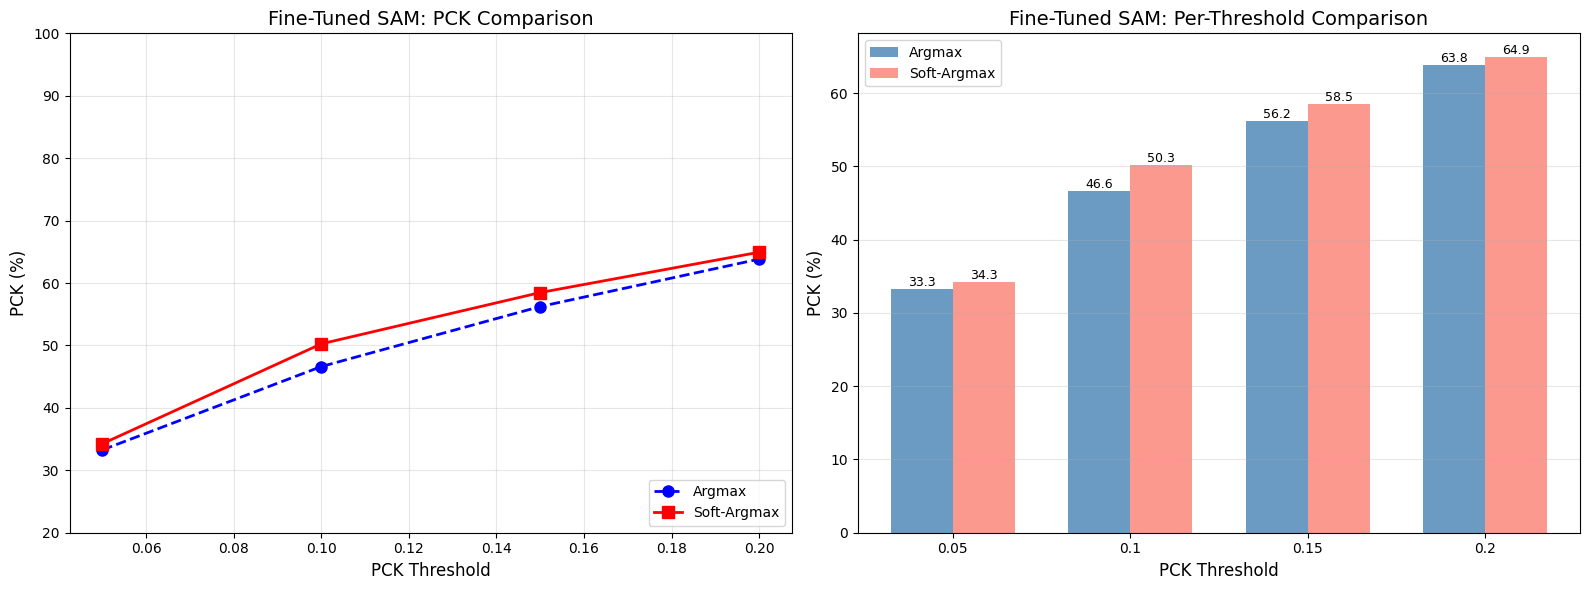


Key Insights:
- Soft-argmax provides sub-pixel precision on the fine-tuned model
- The improvement is especially beneficial at stricter thresholds
- The fine-tuned model with soft-argmax combines both advantages:
  1. Better feature representations from fine-tuning
  2. More precise localization from soft-argmax
- This makes predictions more robust and accurate


In [ ]:
# =============================================================================
# VISUALIZATION: Comparison Plot for Fine-Tuned Model
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCK across thresholds for both methods
ax1 = axes[0]
thresholds = CONFIG['pck_thresholds']

ax1.plot(thresholds, finetuned_argmax_pck, 'b--o', label='Argmax', linewidth=2, markersize=8)
ax1.plot(thresholds, finetuned_soft_pck, 'r-s', label='Soft-Argmax', linewidth=2, markersize=8)

ax1.set_xlabel('PCK Threshold', fontsize=12)
ax1.set_ylabel('PCK (%)', fontsize=12)
ax1.set_title('Fine-Tuned SAM: PCK Comparison', fontsize=14)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([20, 100])

# Plot 2: Bar chart comparing methods at different thresholds
ax2 = axes[1]
x = np.arange(len(CONFIG['pck_thresholds']))
width = 0.35

bars1 = ax2.bar(x - width/2, finetuned_argmax_pck, width, label='Argmax', alpha=0.8, color='steelblue')
bars2 = ax2.bar(x + width/2, finetuned_soft_pck, width, label='Soft-Argmax', alpha=0.8, color='salmon')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('PCK Threshold', fontsize=12)
ax2.set_ylabel('PCK (%)', fontsize=12)
ax2.set_title('Fine-Tuned SAM: Per-Threshold Comparison', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels([f'{t}' for t in CONFIG['pck_thresholds']])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Key Insights:")
print("=" * 70)
print("- Soft-argmax provides sub-pixel precision on the fine-tuned model")
print("- The improvement is especially beneficial at stricter thresholds")
print("- The fine-tuned model with soft-argmax combines both advantages:")
print("  1. Better feature representations from fine-tuning")
print("  2. More precise localization from soft-argmax")
print("- This makes predictions more robust and accurate")

Running hyperparameter study...
Using VALIDATION split (not test!)
Testing on 200 validation samples
This may take a while as it evaluates multiple configurations.


Evaluating: window_size=3, temperature=0.05

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 3, Temperature: 0.05
Building annotation cache...
✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=3, temperature=0.1

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 3, Temperature: 0.1
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=3, temperature=0.2

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 3, Temperature: 0.2
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=3, temperature=0.5

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 3, Temperature: 0.5
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=5, temperature=0.05

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 5, Temperature: 0.05
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=5, temperature=0.1

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 5, Temperature: 0.1
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=5, temperature=0.2

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 5, Temperature: 0.2
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=5, temperature=0.5

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 5, Temperature: 0.5
Building annotation cache...


✓ Cached 3496 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=7, temperature=0.05

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 7, Temperature: 0.05
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=7, temperature=0.1

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 7, Temperature: 0.1
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=7, temperature=0.2

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 7, Temperature: 0.2
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=7, temperature=0.5

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 7, Temperature: 0.5
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=9, temperature=0.05

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 9, Temperature: 0.05
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=9, temperature=0.1

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 9, Temperature: 0.1
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=9, temperature=0.2

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 9, Temperature: 0.2
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

Evaluating: window_size=9, temperature=0.5

EVALUATION - SOFT_ARGMAX on VAL split
  Window Size: 9, Temperature: 0.5
Building annotation cache...


✓ Cached 3497 annotations
✓ Loaded 0 pairs with annotations (val)
  Skipped 200 pairs without annotations
✓ Categories: 0 - 


Evaluating (soft_argmax): 0it [00:00, ?it/s]


Overall Results (Per-Keypoint):
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Mean Per-Image PCK:
  PCK@0.05: 0.00%
  PCK@0.1: 0.00%
  PCK@0.15: 0.00%
  PCK@0.2: 0.00%

Per-Category Results (PCK@0.1):

HYPERPARAMETER STUDY RESULTS
 window_size  temperature  PCK@0.05  PCK@0.1  PCK@0.15  PCK@0.2
           3         0.05      0.00     0.00      0.00     0.00
           3         0.10      0.00     0.00      0.00     0.00
           3         0.20      0.00     0.00      0.00     0.00
           3         0.50      0.00     0.00      0.00     0.00
           5         0.05      0.00     0.00      0.00     0.00
           5         0.10      0.00     0.00      0.00     0.00
           5         0.20      0.00     0.00      0.00     0.00
           5         0.50      0.00     0.00      0.00     0.00
           7         0.05      0.00     0.00      0.00     0.00
           7         0.10      0.00     0.00      0.00     0.00
           7         0.20      0.00    

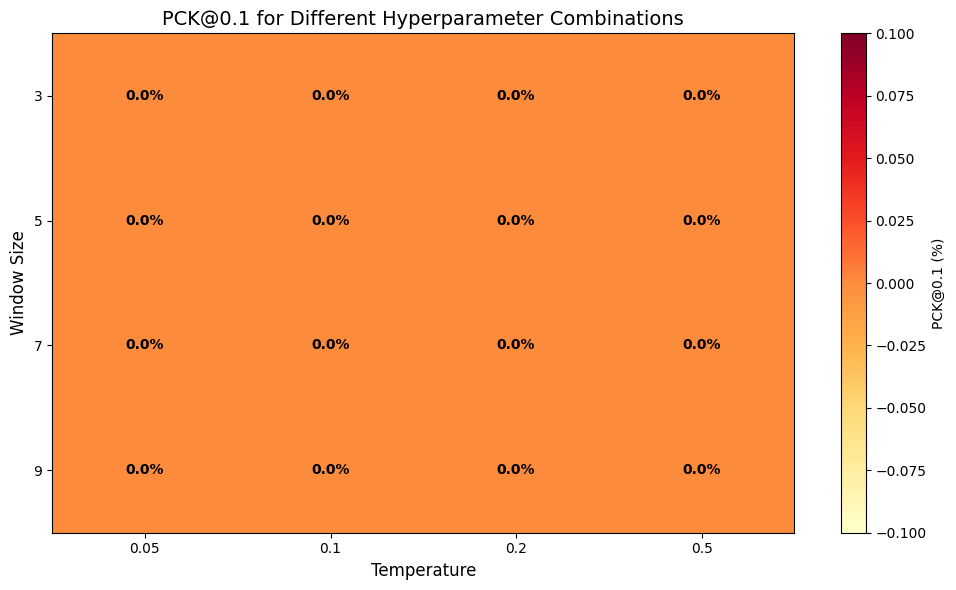


⚠️  Results based on VALIDATION set (200 samples)
   ✓ This is correct - hyperparameters should be tuned on validation!
   💡 Final evaluation on TEST set should be done separately


In [ ]:
# =============================================================================
# HYPERPARAMETER STUDY
# =============================================================================

# Set to True to run hyperparameter study (may take some time)
RUN_HYPERPARAM_STUDY = True

# Number of samples for quick hyperparameter search (set to None for full validation set)
# Recommended: 200-500 for fast tuning, then test best config on full validation set
HYPERPARAM_MAX_SAMPLES = 200

if RUN_HYPERPARAM_STUDY:
    print("Running hyperparameter study...")
    print(f"Using VALIDATION split (not test!)")
    print(f"Testing on {HYPERPARAM_MAX_SAMPLES if HYPERPARAM_MAX_SAMPLES else 'ALL'} validation samples")
    print("This may take a while as it evaluates multiple configurations.\n")

    # Temporarily override config for validation split
    original_max_samples = CONFIG['max_samples']
    original_split = 'val'  # Use validation set for hyperparameter tuning!
    CONFIG['max_samples'] = HYPERPARAM_MAX_SAMPLES

    # Define parameter grid
    window_sizes = [3, 5, 7, 9]
    temperatures = [0.05, 0.1, 0.2, 0.5]

    # Store results
    hyperparam_results = []

    for ws in window_sizes:
        for temp in temperatures:
            print(f"\nEvaluating: window_size={ws}, temperature={temp}")

            results_hp = evaluate_with_prediction_method(
                model = finetuned_sam,
                prediction_method='soft_argmax',
                window_size=ws,
                temperature=temp,
                split='val'  # ✅ Use validation split for hyperparameter tuning!
            )

            hyperparam_results.append({
                'window_size': ws,
                'temperature': temp,
                'PCK@0.05': results_hp['overall']['PCK@0.05'],
                'PCK@0.1': results_hp['overall']['PCK@0.1'],
                'PCK@0.15': results_hp['overall']['PCK@0.15'],
                'PCK@0.2': results_hp['overall']['PCK@0.2']
            })

    # Create results DataFrame
    df_hyperparam = pd.DataFrame(hyperparam_results)
    print("\n" + "=" * 70)
    print("HYPERPARAMETER STUDY RESULTS")
    print("=" * 70)
    print(df_hyperparam.to_string(index=False, float_format='%.2f'))

    # Find best configuration
    best_idx = df_hyperparam['PCK@0.1'].idxmax()
    best_config = df_hyperparam.iloc[best_idx]
    print(f"\n✓ Best configuration for PCK@0.1:")
    print(f"  Window Size: {int(best_config['window_size'])}")
    print(f"  Temperature: {best_config['temperature']}")
    print(f"  PCK@0.1: {best_config['PCK@0.1']:.2f}%")

    # Visualize results as heatmap
    fig, ax = plt.subplots(figsize=(10, 6))

    # Pivot for heatmap
    pivot_data = df_hyperparam.pivot(index='window_size', columns='temperature', values='PCK@0.1')

    im = ax.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')

    ax.set_xticks(range(len(temperatures)))
    ax.set_yticks(range(len(window_sizes)))
    ax.set_xticklabels(temperatures)
    ax.set_yticklabels(window_sizes)
    ax.set_xlabel('Temperature', fontsize=12)
    ax.set_ylabel('Window Size', fontsize=12)
    ax.set_title('PCK@0.1 for Different Hyperparameter Combinations', fontsize=14)

    # Add value labels
    for i in range(len(window_sizes)):
        for j in range(len(temperatures)):
            ax.text(j, i, f'{pivot_data.values[i, j]:.1f}%',
                    ha='center', va='center', fontsize=10, fontweight='bold')

    plt.colorbar(im, ax=ax, label='PCK@0.1 (%)')
    plt.tight_layout()
    plt.show()

    # Restore original max_samples
    CONFIG['max_samples'] = original_max_samples

    print(f"\n⚠️  Results based on VALIDATION set ({HYPERPARAM_MAX_SAMPLES if HYPERPARAM_MAX_SAMPLES else 'ALL'} samples)")
    print(f"   ✓ This is correct - hyperparameters should be tuned on validation!")
    print(f"   💡 Final evaluation on TEST set should be done separately")

else:
    print("Hyperparameter study skipped.")
    print("Set RUN_HYPERPARAM_STUDY = True to run this analysis.")
    print(f"\nUsing current parameters:")
    print(f"  Window Size: {SOFTARGMAX_CONFIG['window_size']}")
    print(f"  Temperature: {SOFTARGMAX_CONFIG['temperature']}")
    print(f"\nTo tune hyperparameters:")
    print(f"  1. Set RUN_HYPERPARAM_STUDY = True")
    print(f"  2. Adjust HYPERPARAM_MAX_SAMPLES (200-500 for speed, None for full validation set)")